<a href="https://colab.research.google.com/github/paraxioms/Notebook_Store/blob/main/UnderSamplingAndOversamplingInvestigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we compare different undersampling and oversampling techniques to try and improve the classification of rain and non-rain samples. We do this as 90% of the data is non-rain and models are heavily biases towards predicting non-rain samples.

A lot of the preprocessing code is repeated/similar to the Two-Step ML notebook.

### Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score

from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
inputFile = "FINCH.txt"
df = pd.read_csv(inputFile, parse_dates=['DATE_TIME'])
df = df.drop(['SITE_ID'], axis=1)
df = df.dropna(subset=['PRECIP'])

In [ ]:
y = df['PRECIP']
df = df.drop(['PRECIP'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [ ]:
from scipy.stats import skew


featureSkewTestCols = list(df.columns.drop('DATE_TIME'))
skew_features = df[featureSkewTestCols].apply(lambda x: skew(x, nan_policy='omit')).sort_values(ascending=False)
skew_features_DF = pd.DataFrame(skew_features, columns=['Skew'])

In [ ]:
def convertToClassification(dataSeries):
  newDataSeries = dataSeries.copy()
  for i in dataSeries.index:
    if dataSeries[i]>0:
      newDataSeries[i] = 1
    elif dataSeries[i] == 0:
      newDataSeries[i] = 0
    else:
      print("ERROR precip < 0 or NaN present")
  return newDataSeries

y_train_c = convertToClassification(y_train)
y_test_c = convertToClassification(y_test)
y_train_c.head(10)


27881    1.0
11231    1.0
24704    0.0
33362    0.0
1643     0.0
29344    0.0
20810    0.0
6054     0.0
9164     1.0
32676    0.0
Name: PRECIP, dtype: float64

In [ ]:
X_train = X_train.sort_index(axis=0)
X_train_time = X_train.set_index('DATE_TIME')
y_train = y_train.sort_index(axis=0)
y_train_time = y_train.rename(X_train['DATE_TIME'])


In [ ]:
eaCols = [i for i in df.columns if i[0:2]=='ea']
TSOILCols = [i for i in df.columns if "TSOIL" in i]
interpolateCols = TSOILCols + ['PA']

In [ ]:
def interpolateEachSeries(missingData, colsToImpute):
  imputedData = pd.Series([])
  for i,col in enumerate(missingData.columns):
    seriesCol = missingData[col]
    if col in colsToImpute:
      imputedCol = seriesCol.interpolate(method='time', limit_direction='both', order=2, limit=2)
    else:
      imputedCol = seriesCol
    imputedData = pd.concat([imputedData, imputedCol], axis=1)
  imputedData = imputedData.drop(imputedData.columns[0], axis=1)
  print("Missing values interpolated:",(np.sum(np.isnan(X_train.drop('DATE_TIME',axis=1).to_numpy())))-(np.sum(np.isnan(imputedData.to_numpy()))))
  return imputedData

timeImputed = interpolateEachSeries(X_train.set_index('DATE_TIME'), interpolateCols)
X_train = timeImputed.set_index(X_train.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Missing values interpolated: 32


In [ ]:
y_train_c = y_train_c.sort_index(axis=0)

In [ ]:
X_test_time = X_test.set_index('DATE_TIME')
X_test = X_test.drop(['DATE_TIME'],axis=1)

In [ ]:
y_test_c = y_test_c.reset_index()
y_test_c = y_test_c.drop("index", axis=1)

In [ ]:
y_test = y_test.reset_index()
y_test = y_test.drop("index",axis=1)

In [ ]:
import datetime as dt
def minus_hours(time_string,hours):
  the_datetime = dt.datetime.strptime(time_string, '%Y-%m-%d %H:%M:%S')
  new_datetime = the_datetime + dt.timedelta(hours=-hours)
  return new_datetime.strftime('%Y-%m-%d %H:%M:%S')
minus_hours('2017-06-08 11:30:00',1)

'2017-06-08 10:30:00'

In [ ]:
def calculatePastRainfall(datetime_string, hours):
  """Returns the sum of rainfall in the past X hours.  Does NOT include the recorded rainfall at the current time. """
  datesToTry = pd.date_range(start=minus_hours(datetime_string,hours), end=minus_hours(datetime_string,0.5), freq='0.5H')
  validDates = [i for i in datesToTry if i in X_train_time.index]
  correspondingRainfall = [y_train_time[i] for i in validDates]
  rainfall = sum(correspondingRainfall)
  return rainfall
calculatePastRainfall('2017-06-08 11:30:00',24)

2.2500000000000004

In [ ]:
def calculateAverageRainfall(datetime_string, hours):
  """Returns the sum of rainfall in the past X hours.  Does NOT include the recorded rainfall at the current time. """
  datesToTry = pd.date_range(start=minus_hours(datetime_string,hours), end=minus_hours(datetime_string,0.5), freq='0.5H')
  validDates = [i for i in datesToTry if i in X_train_time.index]
  correspondingRainfall = [y_train_time[i] for i in validDates]
  try:
    rainfall = sum(correspondingRainfall)/len(correspondingRainfall)
  except:
    rainfall = np.nan
  return rainfall
calculateAverageRainfall('2017-06-08 11:30:00',24)

0.06081081081081082

In [ ]:
def calculateAllRainfall(data, hours):
  """Returns series of all data that rainfall that occured in the past X hours."""
  pastRainfallList = []
  for i in data.index:
    pastRainfall = calculateAverageRainfall(str(i), hours)
    pastRainfallList.append(pastRainfall)
  pastRainfallSeries = pd.Series(data=pastRainfallList, index=X_train.index)
  return pastRainfallSeries
#past24hourrainfall = calculateAllRainfall(X_train_time,24)
#past12hourrainfall = calculateAllRainfall(X_train_time,12)
past6hourrainfall = calculateAllRainfall(X_train_time,6)
#past3hourrainfall = calculateAllRainfall(X_train_time,3)
#past2hourrainfall = calculateAllRainfall(X_train_time,2)
#past1hourrainfall = calculateAllRainfall(X_train_time,1)

In [ ]:
X_trainNew = X_train.copy()
X_trainNew["6Hr-Precip"] = past6hourrainfall

In [ ]:
def calculateAllRainfallTest(data, hours):
  """Returns series of all data that rainfall that occured in the past X hours. Only uses training data."""
  pastRainfallList = []
  for i in data.index:
    pastRainfall = calculateAverageRainfall(str(i), hours)
    pastRainfallList.append(pastRainfall)
  pastRainfallSeries = pd.Series(data=pastRainfallList, index=X_test.index)
  return pastRainfallSeries

#past24hourrainfallTest = calculateAllRainfallTest(X_test_time,24)
#past12hourrainfallTest = calculateAllRainfallTest(X_test_time,12)
past6hourrainfallTest = calculateAllRainfallTest(X_test_time,6)
#past3hourrainfallTest = calculateAllRainfallTest(X_test_time,3)
#past2hourrainfallTest = calculateAllRainfallTest(X_test_time,2)
#past1hourrainfallTest = calculateAllRainfallTest(X_test_time,1)

In [ ]:
X_testNew = X_test.copy()

X_testNew["6Hr-Precip"] = past6hourrainfallTest


In [ ]:
print("Number NANs in 6-Hour Precip Column (Train):", np.sum(np.isnan(X_trainNew["6Hr-Precip"].to_numpy())))
print("Number NANs in 6-Hour Precip Column (Test):", np.sum(np.isnan(X_testNew["6Hr-Precip"].to_numpy())))



Number NANs in 6-Hour Precip Column (Train): 1
Number NANs in 6-Hour Precip Column (Test): 0


### Test data Imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
impute_estimator =   ExtraTreesRegressor(n_estimators=1, random_state=0)
missForest = IterativeImputer(random_state=0, estimator=impute_estimator).fit(X_trainNew) #Fit on the training data only
X_test_missF = missForest.transform(X_testNew) #transform the test data only
X_test_missF_DF = pd.DataFrame(data = X_test_missF, columns=X_testNew.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### Training Data Imputation

We have a choice to make between deletion based methods and imputation based methods. 

Option A: imputing

In [ ]:
#As we have already fitted miss forest on the training data, when imputing the test data we 
#X_train_missF = missForest.transform(X_trainNew)
#X_train2 = pd.DataFrame(data = X_train_missF, columns=X_trainNew.columns, index=X_trainNew.index)

Option B: Deleting

In [ ]:
X_train2 = X_trainNew.dropna()
def removeUneccessaryPrecip(Xdf, ySeries):
  """Deletes precipitation target values if there is no matching index in the test data """
  newYSeries = ySeries.copy()
  for i in newYSeries.index:
    if i not in Xdf.index:
      newYSeries.drop(i, inplace=True)
  return newYSeries

y_train_c = removeUneccessaryPrecip(X_train2, y_train_c)

### Transforming Features

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

X_train2 = X_train2.copy()
X_test2 = X_test_missF_DF.copy()
badTransforms = ['PRECIP','COV_UY_UZ', 'COV_TS_UX', 'COV_TS_UY', 'COV_TS_UZ', 'COV_UX_UY', 'COV_UX_UZ', 'COV_UY_UZ', 'interpol_mod', 'month_sin', 'month_cos', 'hour_cos', 'hour_sin', 'HS', 'CTS_MOD_RH', 'UZ']
eaTransforms = [i for i in skew_features.index if i[0:2]=='ea']
TDTdata = [i for i in skew_features.index if i[0:3]=='TDT']
print(TDTdata)
print(eaTransforms)
print("Features being made positive: \n")
for i in skew_features.index:
  #We cannot take a logarithm/boxcox of negative numbers, so we make them positive by adding a constant (this changes mean but not variance)
  if abs(skew_features[i])>0.8 and (i not in badTransforms) and (min(X_train2[i])<0 or min(X_test2[i]<0)):
    print(i)
    minVal = min(min(X_train2[i]),min(X_test2[i])) # Could just change this to a different constant
    X_train2[i] = X_train2[i] - minVal # Ensure the exact transform is done to both train and test data
    X_test2[i] = X_test2[i] - minVal

print("---")
print("Features being transformed to reduce skew: \n")
for i in skew_features.index:
  if abs(skew_features[i])>0.8 and (i not in badTransforms) and (i not in eaTransforms):
    print(i)
    X_test2[i] = boxcox1p(X_test2[i], boxcox_normmax(X_train2[i] + 1)) #Make sure to transform test data first
    X_train2[i] = boxcox1p(X_train2[i], boxcox_normmax(X_train2[i] + 1))
    #X_train2[i] = np.log1p(X_train2) 
    #X_test2[i] = np.log1p(X_test2) 
skew_features2 = X_train2.apply(lambda x: skew(x, nan_policy='omit')).sort_values(ascending=False)
skew_features_DF2 = pd.DataFrame(skew_features2, columns=['Skew'])
skew_features_DF2.head(20)

['TDT3_TSOIL', 'TDT4_TSOIL', 'TDT1_TSOIL', 'TDT2_TSOIL', 'TDT5_TSOIL', 'TDT6_TSOIL', 'TDT8_TSOIL', 'TDT7_TSOIL', 'TDT10_TSOIL', 'TDT9_TSOIL', 'TDT5_SOILPERM', 'TDT8_SOILPERM', 'TDT3_SOILPERM', 'TDT5_VWC', 'TDT2_SOILPERM', 'TDT4_SOILPERM', 'TDT6_SOILPERM', 'TDT7_SOILPERM', 'TDT8_VWC', 'TDT1_SOILPERM', 'TDT2_VWC', 'TDT3_VWC', 'TDT6_VWC', 'TDT10_SOILPERM', 'TDT7_VWC', 'TDT4_VWC', 'TDT1_VWC', 'TDT10_VWC', 'TDT9_VWC', 'TDT9_SOILPERM']
['ea_196631', 'ea_EDERER', 'ea_194080', 'ea_SHIPDR', 'ea_195140', 'ea_188753', 'ea_190329', 'ea_199736', 'ea_191434']
Features being made positive: 

SWOUT
SWIN
RN
G2
G1
---
Features being transformed to reduce skew: 

TAU
U_STAR
SWOUT
SWIN
RN
G2
G1
E_SAT_MEAN
WS
WS_RES
TDT9_VWC
RH
TDT9_SOILPERM


,Skew
ea_196631,28.766098
ea_EDERER,24.586177
ea_194080,20.422713
ea_SHIPDR,17.316941
ea_190329,14.793910
ea_188753,13.918036
ea_199736,13.861755
COV_UY_UZ,13.520101
ea_195140,12.725635
ea_191434,11.167558


# Sampling Methods

In [ ]:
X_train2

,interpol_mod,COV_TS_UX,COV_TS_UY,COV_TS_UZ,COV_UX_UY,COV_UX_UZ,COV_UY_UZ,CTS_MOD,CTS_MOD_RH,E_SAT_MEAN,G1,G2,HS,LWIN,LWOUT,PA,Q,RHO_A_MEAN,RH,RN,STP_TSOIL50,STP_TSOIL20,STP_TSOIL10,STP_TSOIL5,STP_TSOIL2,SWIN,SWOUT,TA,TAU,TDT1_VWC,TDT1_TSOIL,TDT1_SOILPERM,TDT2_VWC,TDT2_TSOIL,TDT2_SOILPERM,TDT3_VWC,TDT3_TSOIL,TDT3_SOILPERM,TDT4_VWC,TDT4_TSOIL,...,TDT5_TSOIL,TDT5_SOILPERM,TDT6_VWC,TDT6_TSOIL,TDT6_SOILPERM,TDT7_VWC,TDT7_TSOIL,TDT7_SOILPERM,TDT8_VWC,TDT8_TSOIL,TDT8_SOILPERM,TDT9_VWC,TDT9_TSOIL,TDT9_SOILPERM,TDT10_VWC,TDT10_TSOIL,TDT10_SOILPERM,TNR01C,TS,U_STAR,UX,UZ,UY,WD,WS,WS_RES,month_sin,month_cos,hour_sin,hour_cos,ea_195140,ea_194080,ea_199736,ea_191434,ea_EDERER,ea_196631,ea_190329,ea_188753,ea_SHIPDR,6Hr-Precip
977,0.933,0.011,0.011,-0.004,-0.058,0.026,-0.041,888.0,0.3,0.594496,4.966813,4.236471,-5.398,377.1,383.2,1003.2840,11.25,1.216,1.963164e+06,4.622130,17.95,17.89,16.46,15.59,14.89,1.898361,0.822465,13.10,0.045615,19.04,16.74,9.73,18.50,16.36,9.45,23.58,15.22,12.32,23.82,15.37,...,16.57,6.37,23.06,16.92,12.00,19.09,17.52,9.76,12.84,17.84,6.73,5.494084,17.65,274.797727,2.68,17.61,3.04,13.08,15.30,0.156391,-0.662,-0.026,1.401,64.70835,1.057493,1.047782,0.0,-1.000,-0.866,0.500,3.0,0.0,2.0,0.2,1.2,0.4,0.6,0.4,0.8,2.150000
978,0.533,-0.003,0.030,-0.010,-0.009,0.009,-0.038,880.0,0.3,0.596653,5.132551,4.282292,-12.000,377.6,383.8,1003.2630,11.35,1.215,1.949763e+06,4.581244,17.94,17.73,16.31,15.52,14.90,1.663751,0.771384,13.25,0.038838,18.80,16.67,9.61,18.97,16.32,9.70,23.12,15.24,12.04,23.71,15.38,...,16.48,6.42,22.83,16.82,11.86,18.80,17.42,9.61,12.97,17.78,6.78,6.702946,17.62,287.745987,3.59,17.59,3.31,13.17,15.54,0.145218,-0.014,-0.055,1.298,89.38204,0.914415,0.919532,0.0,-1.000,-0.866,0.500,0.6,0.2,0.4,1.4,0.4,0.0,1.4,0.6,0.4,1.995455
979,0.447,-0.006,0.013,-0.006,0.036,0.020,-0.041,840.0,0.3,0.600296,5.217101,4.304980,-7.785,379.8,384.6,1003.0320,11.49,1.214,1.943086e+06,4.590330,17.93,17.58,16.20,15.46,14.88,1.605563,0.760414,13.48,0.043227,18.74,16.60,9.57,19.15,16.28,9.79,23.18,15.26,12.07,24.17,15.36,...,16.42,6.52,22.48,16.74,11.66,18.57,17.36,9.48,13.08,17.69,6.83,18.053394,17.61,398.896721,3.89,17.58,3.40,13.40,15.75,0.152914,0.024,-0.013,1.731,90.79434,1.124477,1.134044,0.0,-1.000,-0.707,0.707,0.4,0.0,0.4,1.4,0.6,0.4,2.2,0.4,1.0,1.988182
982,0.548,-0.009,0.010,-0.006,-0.049,0.042,-0.051,882.0,0.3,0.603279,5.358547,4.338685,-6.775,379.8,385.4,1002.4740,11.67,1.212,1.969889e+06,4.580619,17.89,17.28,16.00,15.35,14.86,1.587900,0.739717,13.68,0.056874,19.91,16.40,10.20,20.21,16.11,10.36,24.28,15.22,12.74,26.08,15.29,...,16.23,6.91,23.06,16.53,12.00,18.27,17.18,9.33,13.73,17.48,7.12,16.890000,17.54,387.524455,4.61,17.53,3.62,13.63,15.86,0.173203,-1.096,-0.033,0.807,36.36473,0.950060,0.952564,0.0,-1.000,-0.500,0.866,1.0,0.4,0.8,0.0,0.0,0.2,1.0,0.2,0.0,2.328889
983,0.809,-0.024,0.004,-0.009,-0.044,0.053,-0.037,873.0,0.3,0.604165,5.373390,4.341057,-11.140,379.2,385.6,1002.0380,11.74,1.211,1.976630e+06,4.571222,17.87,17.20,15.94,15.32,14.84,1.582171,0.730725,13.75,0.055888,20.44,16.34,10.49,21.02,16.04,10.82,24.80,15.20,13.06,26.83,15.24,...,16.19,7.10,23.24,16.46,12.11,18.21,17.11,9.30,14.03,17.42,7.26,26.512519,17.53,459.958744,4.79,17.50,3.68,13.71,15.53,0.171868,-1.370,-0.064,0.908,33.53537,1.072368,1.093144,0.0,-1.000,-0.259,0.966,1.2,0.8,0.6,0.6,0.0,0.4,1.0,0.2,0.2,2.234444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33601,0.482,0.847,-0.404,0.092,-1.327,-0.516,0.046,1030.0,1.1,0.557252,6.690361,4.812995,112.400,363.9,371.3,988.7194,9.07,1.209,1.565564e+06,5.612516,10.03,9.74,9.86,10.19,10.63,3.033546,1.133339,10.72,0.118357,14.44,10.12,7.45,20.44,9.98,10.49,15.04,10.08,7.72,24.34,10.57,...,9.82,7.95,13.50,9.83,7.02,11.54,9.89,6.17,17.09,

In [ ]:
X_train = X_train2.copy()
X_test = X_test2.copy()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [ ]:
X_train = X_train_s
X_test = X_test_s

In [ ]:
from collections import Counter

### Undersampling Methods

### Prototype Generation

ClusterCentroids

In [ ]:
"""#Takes ages
from imblearn.under_sampling import ClusterCentroids
print(sorted(Counter(y_train_c).items()))
cc = ClusterCentroids(random_state=0, sampling_strategy=0.15)
X_resampled_cc, y_resampled_cc = cc.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_cc).items()))"""

'#Takes ages\nfrom imblearn.under_sampling import ClusterCentroids\nprint(sorted(Counter(y_train_c).items()))\ncc = ClusterCentroids(random_state=0, sampling_strategy=0.15)\nX_resampled_cc, y_resampled_cc = cc.fit_resample(X_train, y_train_c)\nprint(sorted(Counter(y_resampled_cc).items()))'

### Prototype Selection

**Controlled Undersampling Technique**

Randomly selecting a subset of the data for the required class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
print(sorted(Counter(y_train_c).items()))
rus = RandomUnderSampler(random_state=0, sampling_strategy=0.14)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_rus).items()))

[(0.0, 18112), (1.0, 1783)]
[(0.0, 12735), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Controlled Undersampling Technique**

NearMiss adds some heuristics. There are 3 different versions, we implement all below.

In [ ]:
from imblearn.under_sampling import NearMiss
print(sorted(Counter(y_train_c).items()))
nm1 = NearMiss(version=1, sampling_strategy=0.14)
X_resampled_nm1, y_resampled_nm1 = nm1.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_nm1).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 12735), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.under_sampling import NearMiss
print(sorted(Counter(y_train_c).items()))
nm2 = NearMiss(version=2, sampling_strategy=0.14)
X_resampled_nm2, y_resampled_nm2 = nm2.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_nm2).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]
[(0.0, 12735), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.under_sampling import NearMiss
print(sorted(Counter(y_train_c).items()))
nm3 = NearMiss(version=3, sampling_strategy=0.14)
X_resampled_nm3, y_resampled_nm3 = nm3.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_nm3).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 2241), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:194: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


**Cleaning UnderSampling Technique** (doesn't allow to select the number of samples in each class)

Tomek's Links

In [ ]:
from imblearn.under_sampling import TomekLinks
print(sorted(Counter(y_train_c).items()))
tl = TomekLinks()
X_resampled_tl, y_resampled_tl = tl.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_tl).items()))

[(0.0, 18112), (1.0, 1783)]
[(0.0, 17838), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Cleaning Undersampling Technique**

Edited Nearet Neighbours

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours
print(sorted(Counter(y_train_c).items()))
enn = EditedNearestNeighbours()
X_resampled_enn, y_resampled_enn = enn.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_enn).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 16691), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Cleaning Undersampling Technique**

Edited Nearet Neighbours (Repeated)

In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
print(sorted(Counter(y_train_c).items()))
renn = RepeatedEditedNearestNeighbours()
X_resampled_renn, y_resampled_renn = renn.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_renn).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[(0.0, 16236), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Cleaning Undersampling Technique**

Edited Nearet Neighbours (All KNN)

In [ ]:
from imblearn.under_sampling import AllKNN
print(sorted(Counter(y_train_c).items()))
allknn = AllKNN()
X_resampled_allknn, y_resampled_allknn = allknn.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_allknn).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[(0.0, 16484), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Cleaning Undersampling Technique**

Condensed Nearest Neighbours

In [ ]:
"""#WARNING: This takes a while to run
from imblearn.under_sampling import CondensedNearestNeighbour
print(sorted(Counter(y_train_c).items()))
cnn = CondensedNearestNeighbour(random_state=0)
X_resampled_cnn, y_resampled_cnn = cnn.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_cnn).items()))"""

'#WARNING: This takes a while to run\nfrom imblearn.under_sampling import CondensedNearestNeighbour\nprint(sorted(Counter(y_train_c).items()))\ncnn = CondensedNearestNeighbour(random_state=0)\nX_resampled_cnn, y_resampled_cnn = cnn.fit_resample(X_train, y_train_c)\nprint(sorted(Counter(y_resampled_cnn).items()))'

**Cleaning Undersampling Technique**

Condensed Nearest Neighbours - One-sided Selection

In [ ]:
from imblearn.under_sampling import OneSidedSelection
print(sorted(Counter(y_train_c).items()))
oss = OneSidedSelection(random_state=0)
X_resampled_oss, y_resampled_oss = oss.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_oss).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 17788), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Cleaning Undersampling Technique**

Condensed Nearest Neighbours - Neighbourhood Cleaning Rule

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
print(sorted(Counter(y_train_c).items()))
ncr = NeighbourhoodCleaningRule()
X_resampled_ncr, y_resampled_ncr = ncr.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_ncr).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 16259), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Instance hardness threshold**

Samples with lower probabilities are removed

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold
print(sorted(Counter(y_train_c).items()))
iht = InstanceHardnessThreshold(random_state=0, sampling_strategy=0.12,
                              estimator=XGBClassifier(learning_rate=0.05, n_estimators=250, reg_lambda=0.6, max_depth=3, gamma=0.15, subsample=1, min_child_weight=1))
X_resampled_iht, y_resampled_iht = iht.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_iht).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]
[(0.0, 14858), (1.0, 1783)]


## Oversampling Methods

**Naive Random Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
print(sorted(Counter(y_train_c).items()))
ros = RandomOverSampler(random_state=0,sampling_strategy=1.0)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_ros).items()))

[(0.0, 18112), (1.0, 1783)]
[(0.0, 18112), (1.0, 18112)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**SMOTE - Synthetic Minority Oversampling Technique**

In [ ]:
from imblearn.over_sampling import SMOTE
print(sorted(Counter(y_train_c).items()))
sm = SMOTE(random_state=0, sampling_strategy=1.0)
X_resampled_sm, y_resampled_sm = sm.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_sm).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 18112)]


**SMOTE** - Borderline SMOTE Varient

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
print(sorted(Counter(y_train_c).items()))
bsm = BorderlineSMOTE(random_state=42,sampling_strategy=1.0)
X_resampled_bsm, y_resampled_bsm = bsm.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_bsm).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 18112)]


**SMOTE** - SVM SMOTE varient

In [ ]:
from imblearn.over_sampling import SVMSMOTE
print(sorted(Counter(y_train_c).items()))
svmsm = SVMSMOTE(random_state=0, sampling_strategy=1.0)
X_resampled_svmsm, y_resampled_svmsm = svmsm.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_svmsm).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

[(0.0, 18112), (1.0, 18112)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**SMOTE** - KMeans SMOTE Varient

**ADASYN** - Adaptive Synethetic Sampling Method

In [ ]:
from imblearn.over_sampling import ADASYN
print(sorted(Counter(y_train_c).items()))
ada = ADASYN(random_state=0, sampling_strategy=1.0)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_ada).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]
[(0.0, 18112), (1.0, 18257)]


### Combined Undersampling/Oversampling Methods

In [ ]:
from imblearn.combine import SMOTEENN
print(sorted(Counter(y_train_c).items()))
smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.80)
X_resampled_smote_enn, y_resampled_smote_enn = smote_enn.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_smote_enn).items()))

[(0.0, 18112), (1.0, 1783)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 16226), (1.0, 14321)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.combine import SMOTETomek
print(sorted(Counter(y_train_c).items()))
smote_tomek = SMOTETomek(random_state=0, sampling_strategy=1)
X_resampled_smote_tomek, y_resampled_smote_tomek = smote_tomek.fit_resample(X_train, y_train_c)
print(sorted(Counter(y_resampled_smote_tomek).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[(0.0, 18112), (1.0, 1783)]
[(0.0, 18103), (1.0, 18103)]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Classification Algorithms

Note, we do not use cross fold validation as it's time consuming and care must be taken when setting it up so that the test set has not been influenced by samples being added or taken away.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
RFC = RandomForestClassifier(n_jobs=-1)

In [ ]:
XGB = XGBClassifier(learning_rate=0.05, n_estimators=250, reg_lambda=0.6, max_depth=3, gamma=0.15, subsample=1, min_child_weight=1)

In [ ]:
GB = GradientBoostingClassifier()

In [ ]:
svc = SVC(C=1, kernel='rbf', degree=5, gamma='scale')

In [ ]:
svcPipeline = make_pipeline(StandardScaler(), svc)

In [ ]:
KNN = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')

In [ ]:
knnPipeline = make_pipeline(StandardScaler(), KNN)

## Fitting Algorithms for each method

In [ ]:
def fitAndPred(X_resampled,y_resampled):
  XGB.fit(X_resampled, y_resampled)
  RFC.fit(X_resampled, y_resampled)
  svcPipeline.fit(X_resampled, y_resampled)
  knnPipeline.fit(X_resampled, y_resampled)

  y_XGB = XGB.predict(X_test)
  y_RFC = RFC.predict(X_test)
  y_SVC = svcPipeline.predict(X_test)
  y_KNN = knnPipeline.predict(X_test)
  return y_XGB, y_RFC, y_SVC, y_KNN


Default

In [ ]:
y_XGB_normal, y_RFC_normal, y_SVC_normal, y_KNN_normal = fitAndPred(X_train, y_train_c)

Random Under Sampling

In [ ]:
y_XGB_rus, y_RFC_rus, y_SVC_rus, y_KNN_rus = fitAndPred(X_resampled_rus, y_resampled_rus)

Near Miss 1

In [ ]:
y_XGB_nm1, y_RFC_nm1, y_SVC_nm1, y_KNN_nm1 = fitAndPred(X_resampled_nm1, y_resampled_nm1)

Near Miss 2

In [ ]:
y_XGB_nm2, y_RFC_nm2, y_SVC_nm2, y_KNN_nm2 = fitAndPred(X_resampled_nm2, y_resampled_nm2)

NearMiss 3

In [ ]:
y_XGB_nm3, y_RFC_nm3, y_SVC_nm3, y_KNN_nm3 = fitAndPred(X_resampled_nm3, y_resampled_nm3)

Tomek's Links

In [ ]:
y_XGB_tl, y_RFC_tl, y_SVC_tl,y_KNN_tl = fitAndPred(X_resampled_tl, y_resampled_tl)

Edited Nearest Neighbours

In [ ]:
y_XGB_enn, y_RFC_enn,y_SVC_enn,y_KNN_enn = fitAndPred(X_resampled_enn, y_resampled_enn)

Repeated Edited Nearest Neighbours

In [ ]:
y_XGB_renn, y_RFC_renn, y_SVC_renn, y_KNN_renn = fitAndPred(X_resampled_renn, y_resampled_renn)

ALL KNN

In [ ]:
y_XGB_allknn, y_RFC_allknn, y_SVC_allknn, y_KNN_allknn = fitAndPred(X_resampled_allknn, y_resampled_allknn)

OSS

In [ ]:
y_XGB_oss, y_RFC_oss,y_SVC_oss, y_KNN_oss = fitAndPred(X_resampled_oss, y_resampled_oss)

Neighbourhood Cleaning Rule

In [ ]:
y_XGB_ncr, y_RFC_ncr,y_SVC_ncr,y_KNN_ncr = fitAndPred(X_resampled_ncr, y_resampled_ncr)

IHT

In [ ]:
y_XGB_iht, y_RFC_iht, y_SVC_iht, y_KNN_iht = fitAndPred(X_resampled_iht, y_resampled_iht)

**Oversampling** 

Random Oversampling

In [ ]:
y_XGB_ros, y_RFC_ros,y_SVC_ros,y_KNN_ros = fitAndPred(X_resampled_ros, y_resampled_ros)

Smote

In [ ]:
y_XGB_sm, y_RFC_sm,y_SVC_sm,y_KNN_sm = fitAndPred(X_resampled_sm, y_resampled_sm)

Borderline SMOTE

In [ ]:
y_XGB_bsm, y_RFC_bsm,y_SVC_bsm,y_KNN_bsm = fitAndPred(X_resampled_bsm, y_resampled_bsm)

SVM SMOTE

In [ ]:
y_XGB_svmsm, y_RFC_svmsm,y_SVC_svmsm,y_KNN_svmsm = fitAndPred(X_resampled_svmsm, y_resampled_svmsm)

ADASYN

In [ ]:
y_XGB_ada, y_RFC_ada,y_SVC_ada,y_KNN_ada = fitAndPred(X_resampled_ada, y_resampled_ada)

** Under-Over **

SMOTE ENN

In [ ]:
y_XGB_smote_enn, y_RFC_smote_enn,y_SVC_smote_enn,y_KNN_smote_enn = fitAndPred(X_resampled_smote_enn, y_resampled_smote_enn)

SMOTE TOMEK

In [ ]:
y_XGB_smote_tomek, y_RFC_smote_tomek,y_SVC_smote_tomek,y_KNN_smote_tomek = fitAndPred(X_resampled_smote_tomek, y_resampled_smote_tomek)

# Evaluation on test data

In [ ]:
 from sklearn.metrics import classification_report
 from sklearn.metrics import confusion_matrix
 from sklearn.metrics import plot_confusion_matrix
 from sklearn.metrics import f1_score
 from sklearn.metrics import roc_auc_score, precision_score, recall_score, balanced_accuracy_score, accuracy_score
 from sklearn.metrics import average_precision_score
 from imblearn.metrics import geometric_mean_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#I did not write the following function - the function plots a confusion matrix nicely - Reference: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix_2(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def evaluateClassification(estimator, X_testData, y_testData, y_predictions):
  cf = confusion_matrix(y_testData, y_predictions, normalize='true')
  plot_confusion_matrix_2(cf, ['Non-Rain', 'Rain'])
  accuracy = accuracy_score(y_testData,  y_predictions)
  balancedAccuracy =  balanced_accuracy_score(y_testData,  y_predictions)
  f1 = f1_score(y_testData,  y_predictions)
  f1Weighted = f1_score(y_testData,  y_predictions, average='weighted')
  AUC =  roc_auc_score(y_testData,  y_predictions, average='weighted')
  averagePrecision = average_precision_score(y_testData, y_predictions, average='weighted')
  precision =  precision_score(y_testData,  y_predictions)
  recall = recall_score(y_testData,  y_predictions) 
  g_mean = geometric_mean_score(y_testData, y_predictions, average='weighted')
  metricNames = ['Accuracy', 'Balanced Accuracy','f1','f1-weighted','AUC','averagePrecision','precision', 'recall', 'g_mean']
  metricList = [accuracy,balancedAccuracy,f1,f1Weighted, AUC, averagePrecision, precision, recall, g_mean]
  if estimator == XGB:
    metricList.append("XGB")
  elif estimator == RFC:
    metricList.append("RFC")
  elif estimator == svcPipeline:
    metricList.append("SVC")
  elif estimator == knnPipeline:
    metricList.append("KNN")
  zippedMetrics = zip(metricNames, metricList)
  for i in zippedMetrics:
    print(i)
  return metricList

In [ ]:
def displayResults(samplingName, y_XGB, y_RFC, y_SVC, y_KNN):
  print(samplingName, "\n")
  print("XGB \n")
  XGB_results = evaluateClassification(XGB, X_test, y_test_c, y_XGB)
  print("\n RFC \n")
  RFC_results = evaluateClassification(RFC, X_test, y_test_c, y_RFC)
  print("\n SVC \n")
  SVC_results = evaluateClassification(svcPipeline, X_test, y_test_c, y_SVC)
  print("\n KNN \n")
  KNN_results = evaluateClassification(knnPipeline, X_test, y_test_c, y_KNN)
  return XGB_results, RFC_results, SVC_results, KNN_results

NO SAMPLING 

XGB 



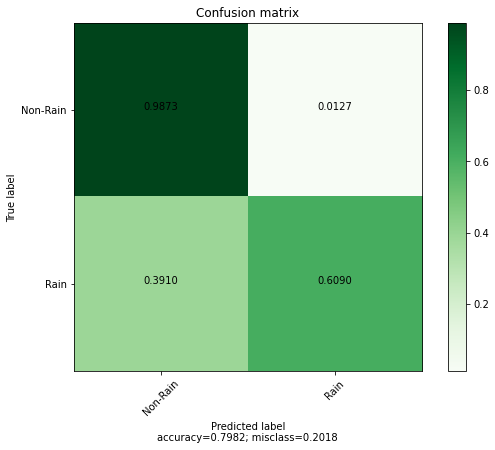

('Accuracy', 0.9498586519863116)
('Balanced Accuracy', 0.798153946623494)
('f1', 0.7061900610287707)
('f1-weighted', 0.9462318644999163)
('AUC', 0.798153946623494)
('averagePrecision', 0.5504152907771648)
('precision', 0.8402489626556017)
('recall', 0.6090225563909775)
('g_mean', 0.7836041123433695)

 RFC 



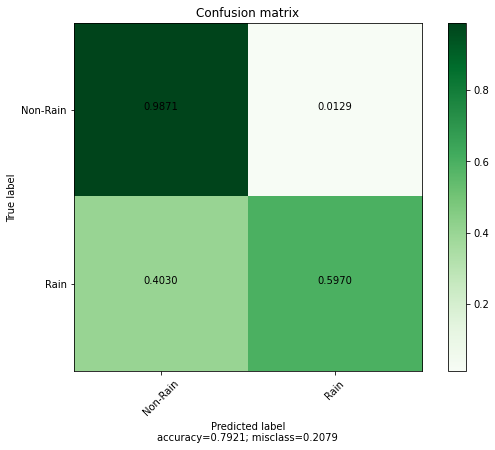

('Accuracy', 0.9485195655408422)
('Balanced Accuracy', 0.7920563462818209)
('f1', 0.6964912280701755)
('f1-weighted', 0.9446270778055612)
('AUC', 0.7920563462818208)
('averagePrecision', 0.5388350502565155)
('precision', 0.8357894736842105)
('recall', 0.5969924812030075)
('g_mean', 0.7764486568372767)

 SVC 



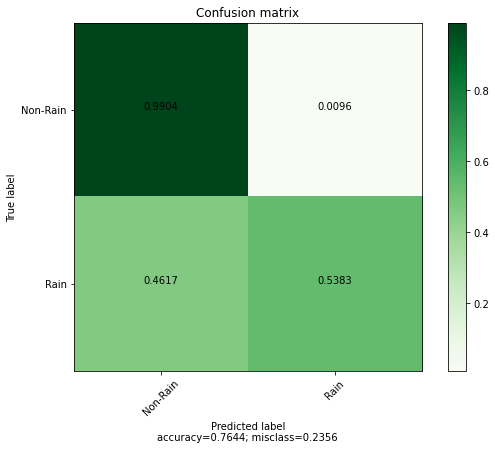

('Accuracy', 0.9456926052670733)
('Balanced Accuracy', 0.764384292964909)
('f1', 0.6623496762257169)
('f1-weighted', 0.9399849449377069)
('AUC', 0.764384292964909)
('averagePrecision', 0.5089657542905024)
('precision', 0.8605769230769231)
('recall', 0.5383458646616541)
('g_mean', 0.7425702951381806)

 KNN 



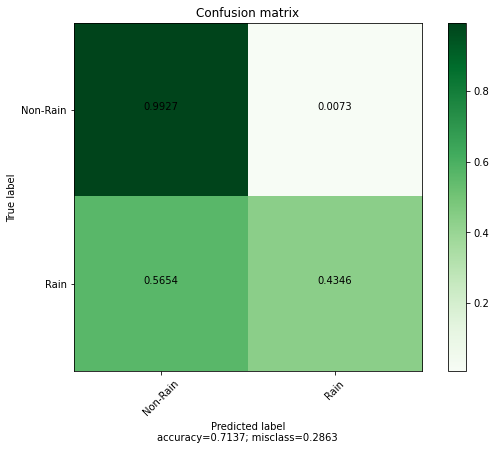

('Accuracy', 0.9375092992114269)
('Balanced Accuracy', 0.7136604721844241)
('f1', 0.5791583166332664)
('f1-weighted', 0.9279486654750118)
('AUC', 0.7136604721844241)
('averagePrecision', 0.43310768573926467)
('precision', 0.8678678678678678)
('recall', 0.4345864661654135)
('g_mean', 0.6776451668809644)


In [ ]:
XGB_normal, RFC_normal, SVC_normal, KNN_normal = displayResults("NO SAMPLING", y_XGB_normal, y_RFC_normal,y_SVC_normal,y_KNN_normal) 

RANDOM UNDERSAMPLING 

XGB 



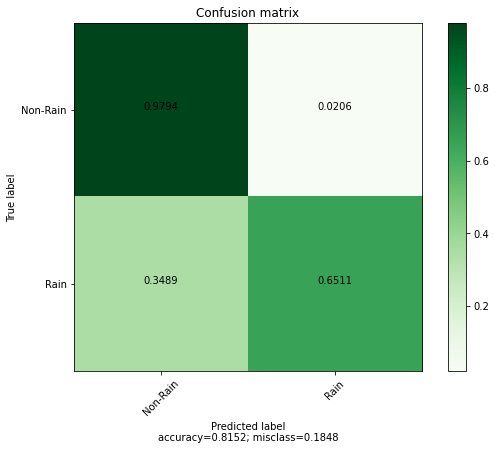

('Accuracy', 0.9468829043297129)
('Balanced Accuracy', 0.8152435663134057)
('f1', 0.7080948487326248)
('f1-weighted', 0.9447918721708711)
('AUC', 0.8152435663134057)
('averagePrecision', 0.5397845256205984)
('precision', 0.7759856630824373)
('recall', 0.6511278195488722)
('g_mean', 0.8045453107824498)

 RFC 



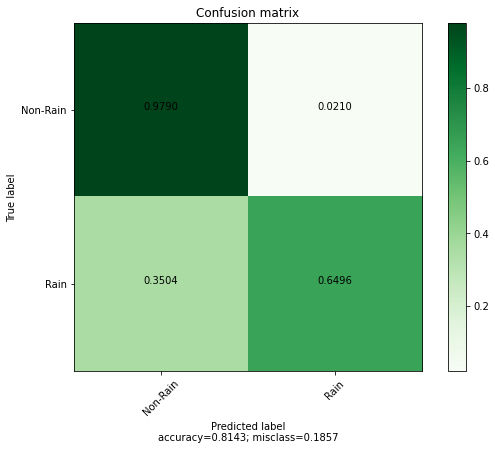

('Accuracy', 0.9464365421812231)
('Balanced Accuracy', 0.8143265611187811)
('f1', 0.7058823529411765)
('f1-weighted', 0.9443495603462708)
('AUC', 0.814326561118781)
('averagePrecision', 0.5367025120508284)
('precision', 0.7728085867620751)
('recall', 0.649624060150376)
('g_mean', 0.803538860944025)

 SVC 



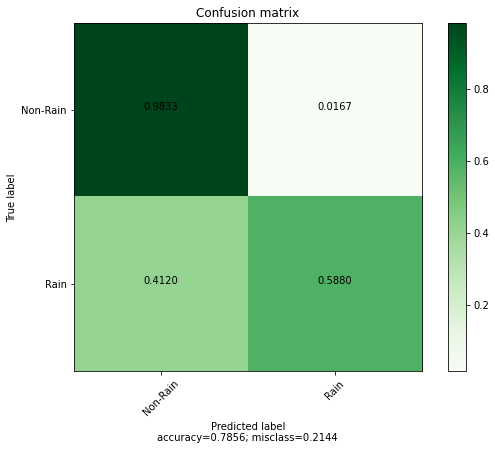

('Accuracy', 0.944204731438774)
('Balanced Accuracy', 0.7856461248895025)
('f1', 0.675885911840968)
('f1-weighted', 0.9404262083789108)
('AUC', 0.7856461248895025)
('averagePrecision', 0.508036524605776)
('precision', 0.7947154471544715)
('recall', 0.58796992481203)
('g_mean', 0.7694796955365651)

 KNN 



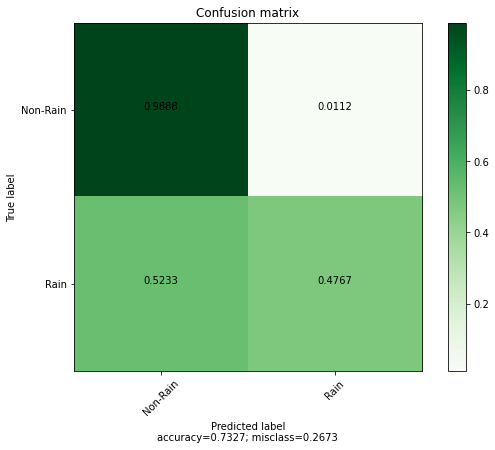

('Accuracy', 0.9381044487427466)
('Balanced Accuracy', 0.7327315978188536)
('f1', 0.6038095238095238)
('f1-weighted', 0.9305509804582643)
('AUC', 0.7327315978188536)
('averagePrecision', 0.44427483570660664)
('precision', 0.8233766233766234)
('recall', 0.4766917293233083)
('g_mean', 0.7033616328358852)


In [ ]:
XGB_RUS, RFC_RUS, SVC_RUS, KNN_RUS = displayResults("RANDOM UNDERSAMPLING", y_XGB_rus, y_RFC_rus, y_SVC_rus, y_KNN_rus)

NEARMISS 1 

XGB 



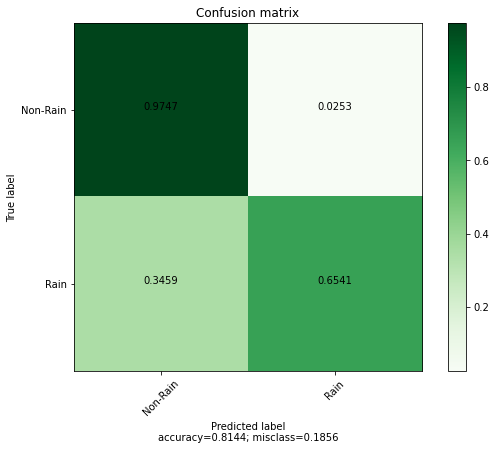

('Accuracy', 0.9430144323761345)
('Balanced Accuracy', 0.8144355687766311)
('f1', 0.6943335993615324)
('f1-weighted', 0.9414434729748608)
('AUC', 0.8144355687766311)
('averagePrecision', 0.5181477514189995)
('precision', 0.7397959183673469)
('recall', 0.6541353383458647)
('g_mean', 0.8042218422325864)

 RFC 



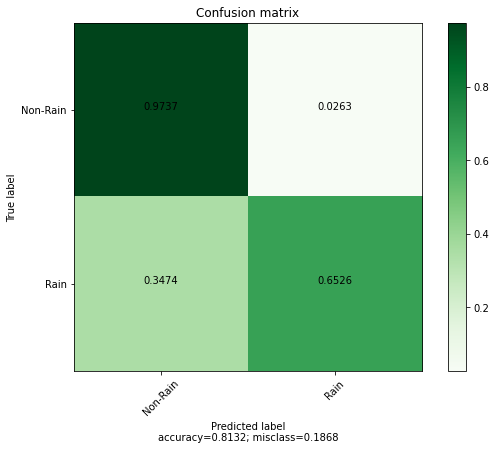

('Accuracy', 0.941972920696325)
('Balanced Accuracy', 0.8131883125912536)
('f1', 0.6899841017488076)
('f1-weighted', 0.9404838206500166)
('AUC', 0.8131883125912536)
('averagePrecision', 0.5120125587274048)
('precision', 0.7318718381112985)
('recall', 0.6526315789473685)
('g_mean', 0.802925747781346)

 SVC 



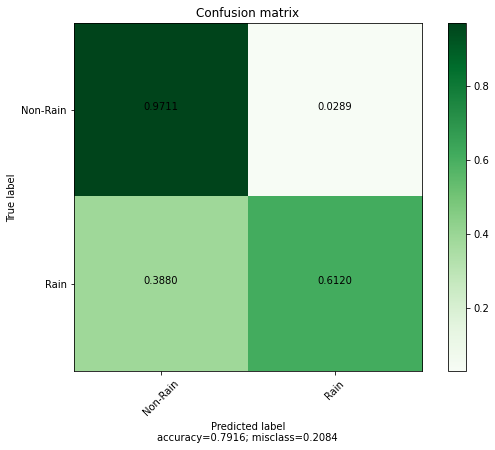

('Accuracy', 0.9355750632346377)
('Balanced Accuracy', 0.7915665567485424)
('f1', 0.652766639935846)
('f1-weighted', 0.9336502498575325)
('AUC', 0.7915665567485425)
('averagePrecision', 0.4663875581747691)
('precision', 0.6993127147766323)
('recall', 0.6120300751879699)
('g_mean', 0.7783567073150893)

 KNN 



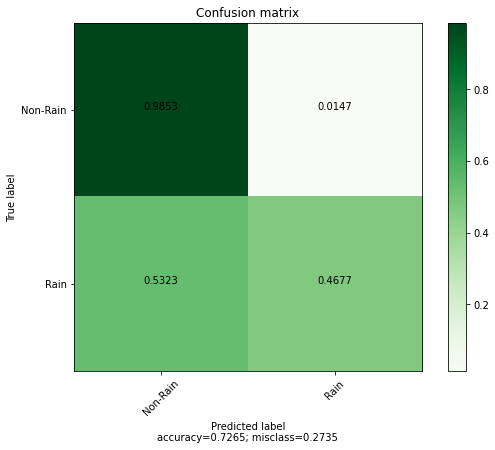

('Accuracy', 0.9340871894063384)
('Balanced Accuracy', 0.7264865019219118)
('f1', 0.584037558685446)
('f1-weighted', 0.926592388393085)
('AUC', 0.7264865019219118)
('averagePrecision', 0.4162835154766846)
('precision', 0.7775)
('recall', 0.46766917293233085)
('g_mean', 0.6961929273058793)


In [ ]:
XGB_NM1, RFC_NM1, SVC_NM1, KNN_NM1 = displayResults("NEARMISS 1", y_XGB_nm1, y_RFC_nm1, y_SVC_nm1, y_KNN_nm1)

NEARMISS 2 

XGB 



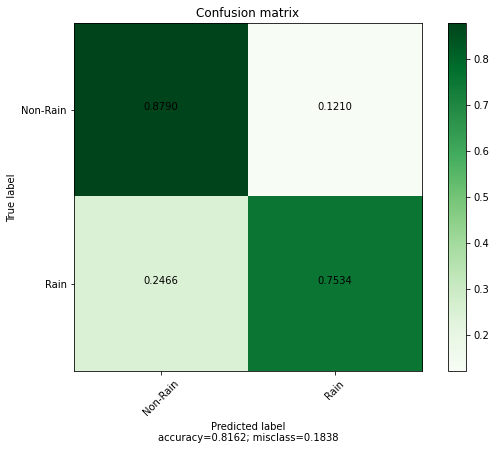

('Accuracy', 0.8665377176015474)
('Balanced Accuracy', 0.8161732352678261)
('f1', 0.5276461295418641)
('f1-weighted', 0.8832430206948473)
('AUC', 0.8161732352678261)
('averagePrecision', 0.3302723729088703)
('precision', 0.4059967585089141)
('recall', 0.7533834586466165)
('g_mean', 0.8146178054074231)

 RFC 



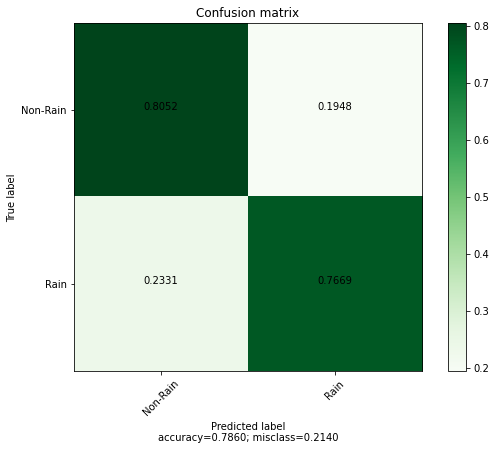

('Accuracy', 0.8013688439220354)
('Balanced Accuracy', 0.7860346043444145)
('f1', 0.43312101910828027)
('f1-weighted', 0.8354135828445662)
('AUC', 0.7860346043444144)
('averagePrecision', 0.2544986239533573)
('precision', 0.30177514792899407)
('recall', 0.7669172932330827)
('g_mean', 0.7858850172407261)

 SVC 



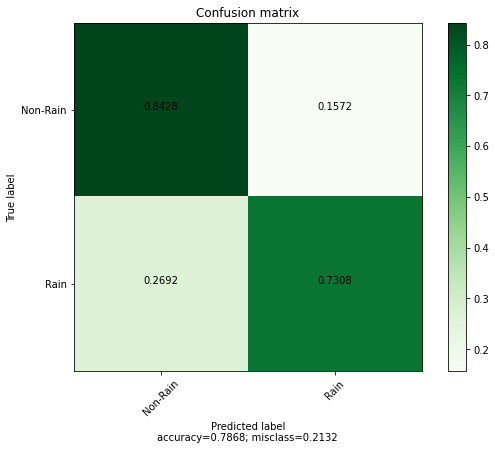

('Accuracy', 0.8317214700193424)
('Balanced Accuracy', 0.7868137980353791)
('f1', 0.46219686162624823)
('f1-weighted', 0.8569126264077243)
('AUC', 0.7868137980353791)
('averagePrecision', 0.2736301285134974)
('precision', 0.3379694019471488)
('recall', 0.7308270676691729)
('g_mean', 0.7855311921087788)

 KNN 



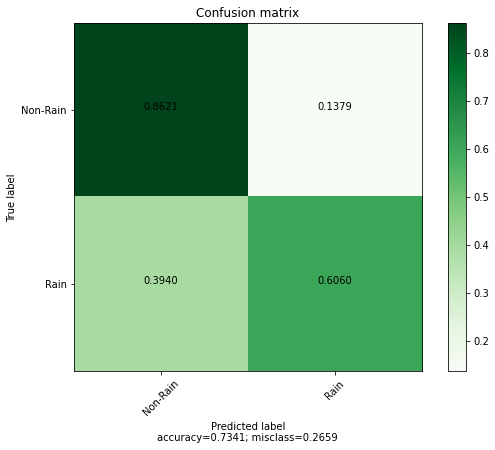

('Accuracy', 0.8367802410355601)
('Balanced Accuracy', 0.7340676244773096)
('f1', 0.42354177614293226)
('f1-weighted', 0.8573007055804494)
('AUC', 0.7340676244773096)
('averagePrecision', 0.23625536388979215)
('precision', 0.3255250403877221)
('recall', 0.606015037593985)
('g_mean', 0.7268461981090071)


In [ ]:
XGB_NM2, RFC_NM2, SVC_NM2, KNN_NM2 = displayResults("NEARMISS 2", y_XGB_nm2, y_RFC_nm2, y_SVC_nm2, y_KNN_nm2)

NEARMISS 3 

XGB 



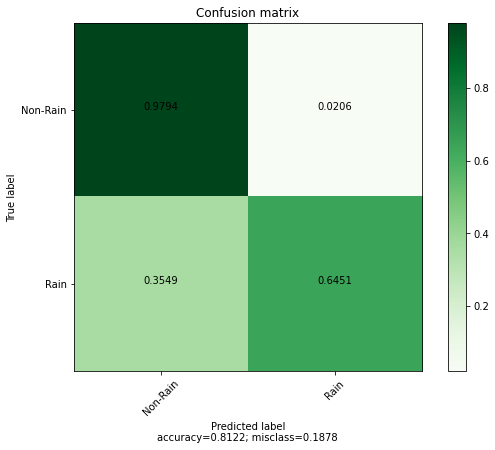

('Accuracy', 0.9462877547983931)
('Balanced Accuracy', 0.8122360475164132)
('f1', 0.7038556193601313)
('f1-weighted', 0.9440861703237432)
('AUC', 0.8122360475164132)
('averagePrecision', 0.5346686661360357)
('precision', 0.7743682310469314)
('recall', 0.6451127819548872)
('g_mean', 0.8010977073115809)

 RFC 



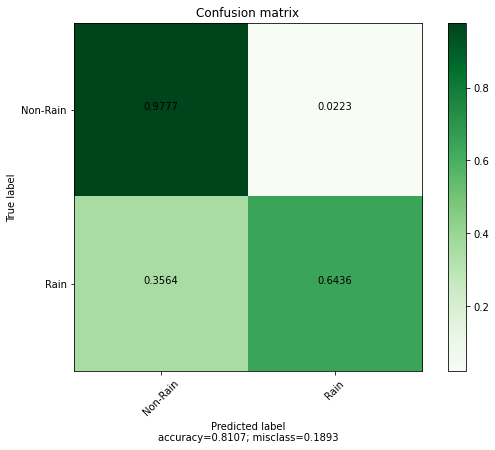

('Accuracy', 0.9446510935872638)
('Balanced Accuracy', 0.8106585403402826)
('f1', 0.6970684039087948)
('f1-weighted', 0.9425835125861827)
('AUC', 0.8106585403402827)
('averagePrecision', 0.5245426481927469)
('precision', 0.7602131438721137)
('recall', 0.643609022556391)
('g_mean', 0.799508139233737)

 SVC 



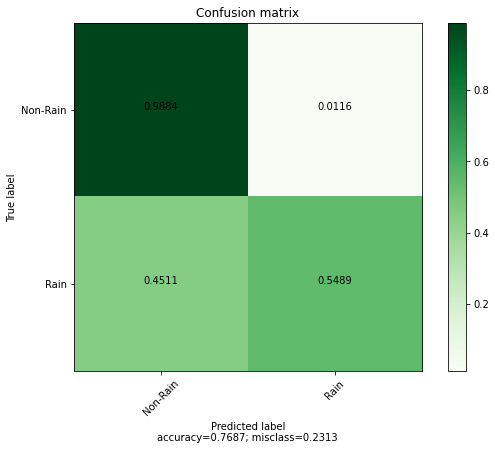

('Accuracy', 0.9449486683529237)
('Balanced Accuracy', 0.7686566978873869)
('f1', 0.6636363636363636)
('f1-weighted', 0.9397062578777324)
('AUC', 0.7686566978873868)
('averagePrecision', 0.5051841363769386)
('precision', 0.8390804597701149)
('recall', 0.5488721804511278)
('g_mean', 0.7481672676323924)

 KNN 



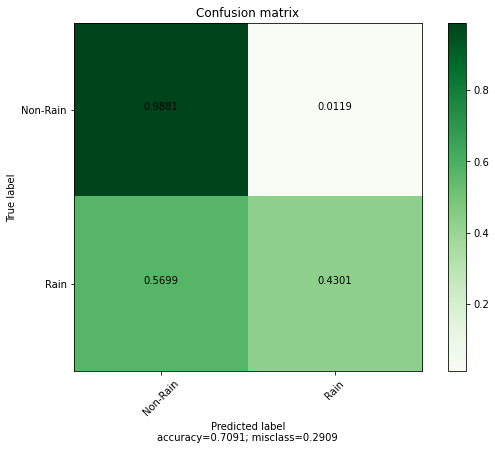

('Accuracy', 0.9328968903436988)
('Balanced Accuracy', 0.7090930761514089)
('f1', 0.5591397849462365)
('f1-weighted', 0.9236575448765099)
('AUC', 0.709093076151409)
('averagePrecision', 0.39997003753220634)
('precision', 0.7988826815642458)
('recall', 0.43007518796992483)
('g_mean', 0.6728483063803095)


In [ ]:
XGB_NM3, RFC_NM3, SVC_NM3, KNN_NM3 = displayResults("NEARMISS 3", y_XGB_nm3, y_RFC_nm3,  y_SVC_nm3,  y_KNN_nm3)

Tomek's Links 

XGB 



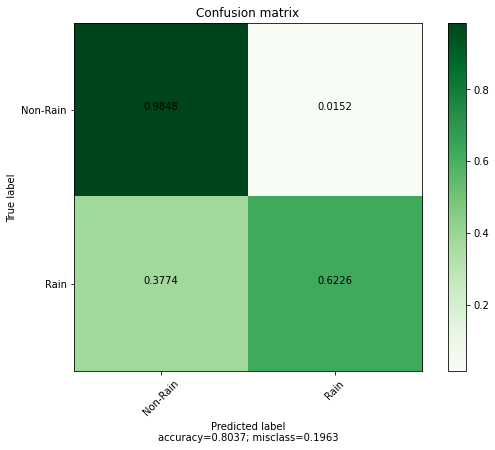

('Accuracy', 0.948965927689332)
('Balanced Accuracy', 0.8036824227014034)
('f1', 0.7070879590093936)
('f1-weighted', 0.9458318231322372)
('AUC', 0.8036824227014034)
('averagePrecision', 0.5467099529809496)
('precision', 0.8181818181818182)
('recall', 0.6225563909774436)
('g_mean', 0.7904417370923804)

 RFC 



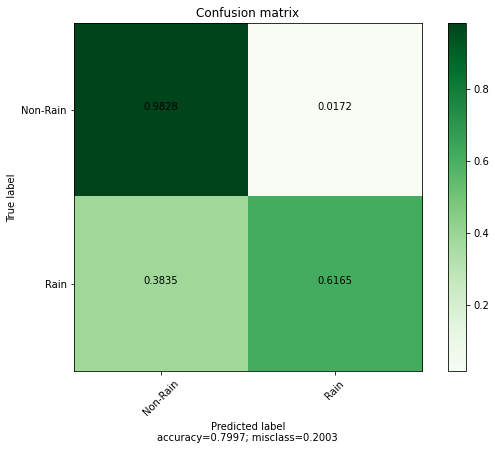

('Accuracy', 0.946585329564053)
('Balanced Accuracy', 0.799684150932152)
('f1', 0.6955046649703138)
('f1-weighted', 0.9434936570244088)
('AUC', 0.7996841509321521)
('averagePrecision', 0.5297344691726416)
('precision', 0.7976653696498055)
('recall', 0.6165413533834586)
('g_mean', 0.786075559325333)

 SVC 



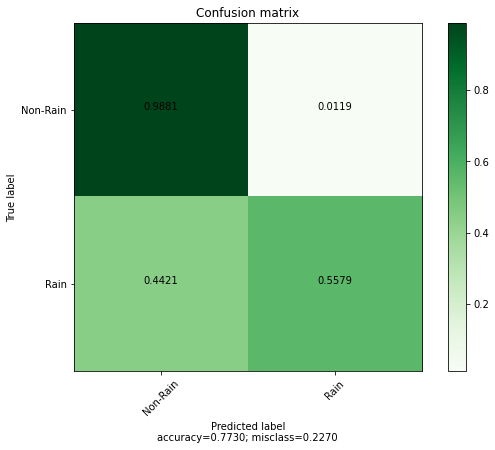

('Accuracy', 0.9455438178842435)
('Balanced Accuracy', 0.7730028505874991)
('f1', 0.6696750902527075)
('f1-weighted', 0.9405784491851839)
('AUC', 0.7730028505874992)
('averagePrecision', 0.5109645907064505)
('precision', 0.837471783295711)
('recall', 0.5578947368421052)
('g_mean', 0.7535005120241812)

 KNN 



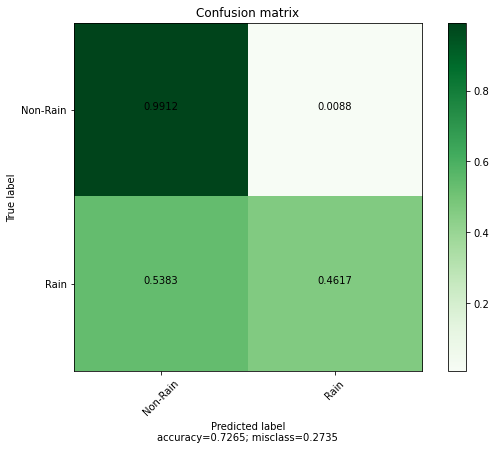

('Accuracy', 0.9388483856568963)
('Balanced Accuracy', 0.726451242041696)
('f1', 0.5990243902439024)
('f1-weighted', 0.9305012552227364)
('AUC', 0.726451242041696)
('averagePrecision', 0.4469542706888731)
('precision', 0.8527777777777777)
('recall', 0.4616541353383459)
('g_mean', 0.6947077518266417)


In [ ]:
XGB_TL, RFC_TL, SVC_TL, KNN_TL = displayResults("Tomek's Links", y_XGB_tl, y_RFC_tl, y_SVC_tl, y_KNN_tl)

Edited Nearest Neighbours 

XGB 



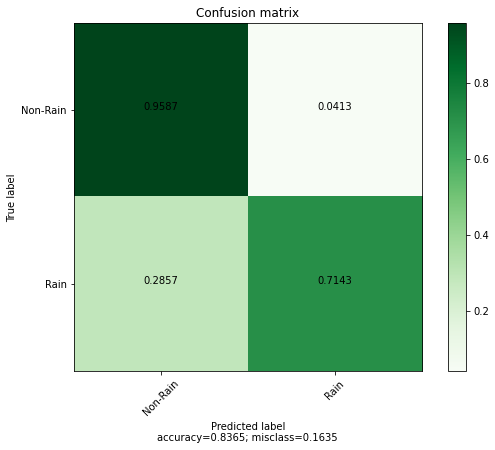

('Accuracy', 0.9345335515548282)
('Balanced Accuracy', 0.8365021702207964)
('f1', 0.683453237410072)
('f1-weighted', 0.9357835365240188)
('AUC', 0.8365021702207964)
('averagePrecision', 0.4962498983041903)
('precision', 0.6551724137931034)
('recall', 0.7142857142857143)
('g_mean', 0.8307380628440254)

 RFC 



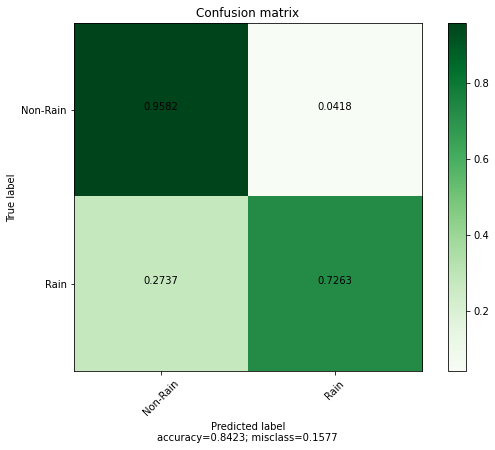

('Accuracy', 0.9352774884689778)
('Balanced Accuracy', 0.8422695195717167)
('f1', 0.6895074946466809)
('f1-weighted', 0.9367266762076526)
('AUC', 0.8422695195717166)
('averagePrecision', 0.5037240405171537)
('precision', 0.65625)
('recall', 0.7263157894736842)
('g_mean', 0.8371185467549841)

 SVC 



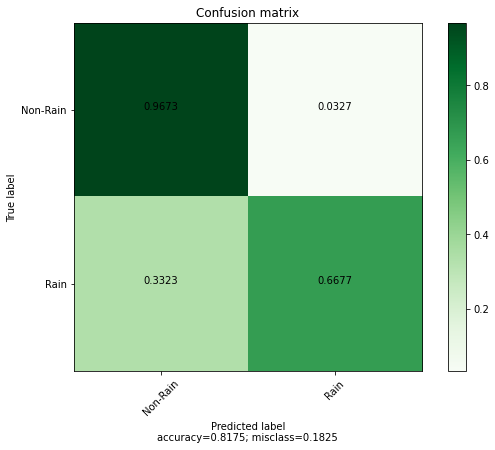

('Accuracy', 0.9376580865942568)
('Balanced Accuracy', 0.8174871624238933)
('f1', 0.6794185156847743)
('f1-weighted', 0.937168633761054)
('AUC', 0.8174871624238933)
('averagePrecision', 0.4946345237268409)
('precision', 0.6915887850467289)
('recall', 0.6676691729323309)
('g_mean', 0.8086063379122808)

 KNN 



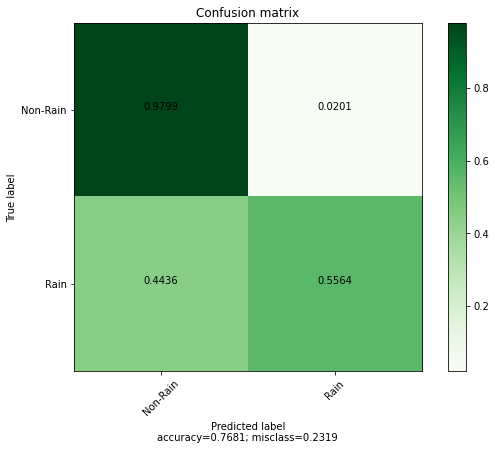

('Accuracy', 0.9379556613599167)
('Balanced Accuracy', 0.7681228335038388)
('f1', 0.6395851339671564)
('f1-weighted', 0.9337539437173489)
('AUC', 0.7681228335038389)
('averagePrecision', 0.46231638698795174)
('precision', 0.7520325203252033)
('recall', 0.556390977443609)
('g_mean', 0.7491124734860407)


In [ ]:
XGB_ENN, RFC_ENN, SVC_ENN, KNN_ENN = displayResults("Edited Nearest Neighbours", y_XGB_enn, y_RFC_enn,  y_SVC_enn,  y_KNN_enn)

Repeated Edited Nearest Neighbours 

XGB 



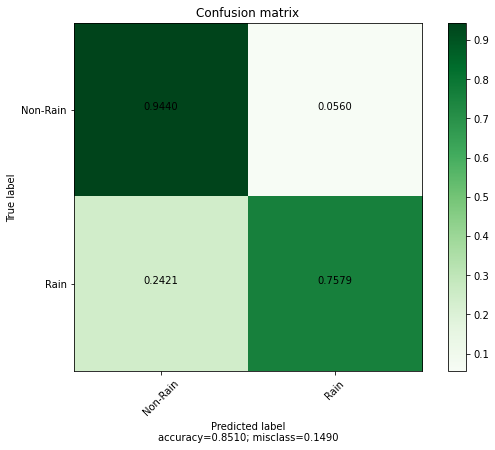

('Accuracy', 0.925606308585032)
('Balanced Accuracy', 0.8509585969547382)
('f1', 0.6684350132625995)
('f1-weighted', 0.9294421130569102)
('AUC', 0.8509585969547383)
('averagePrecision', 0.4770733301639958)
('precision', 0.597864768683274)
('recall', 0.7578947368421053)
('g_mean', 0.8476781540652897)

 RFC 



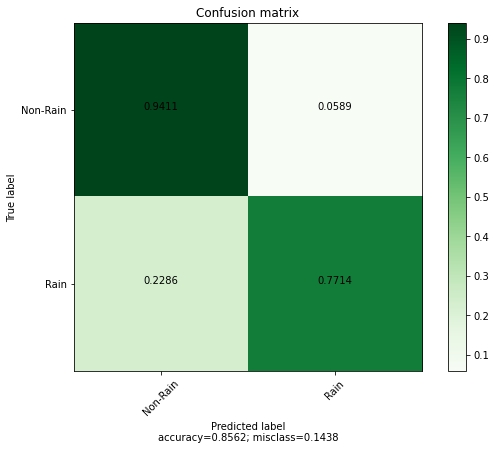

('Accuracy', 0.9242672221395626)
('Balanced Accuracy', 0.856239384789583)
('f1', 0.6684039087947883)
('f1-weighted', 0.9286723602293987)
('AUC', 0.8562393847895828)
('averagePrecision', 0.47749252948079063)
('precision', 0.5896551724137931)
('recall', 0.7714285714285715)
('g_mean', 0.8535327160749776)

 SVC 



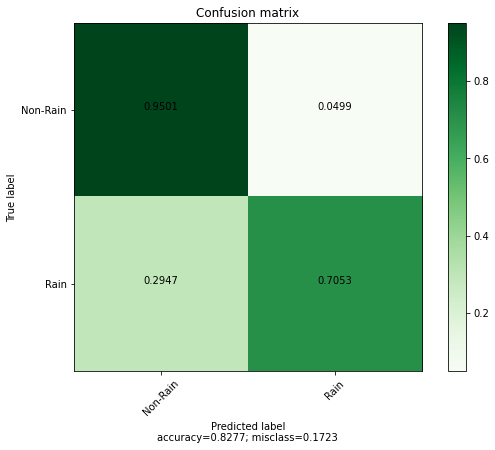

('Accuracy', 0.9259038833506918)
('Balanced Accuracy', 0.8276976291455189)
('f1', 0.6532033426183843)
('f1-weighted', 0.9283115343016851)
('AUC', 0.8276976291455189)
('averagePrecision', 0.458174546298781)
('precision', 0.6083009079118028)
('recall', 0.7052631578947368)
('g_mean', 0.8218508970172765)

 KNN 



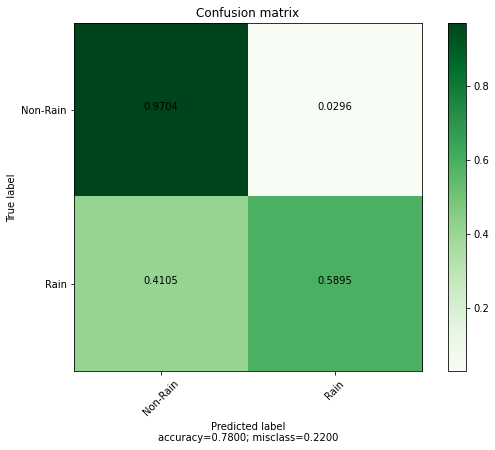

('Accuracy', 0.932748102960869)
('Balanced Accuracy', 0.7799581102690676)
('f1', 0.634304207119741)
('f1-weighted', 0.9304497475447567)
('AUC', 0.7799581102690677)
('averagePrecision', 0.44530141472540313)
('precision', 0.6865148861646234)
('recall', 0.5894736842105263)
('g_mean', 0.7648463060692223)


In [ ]:
XGB_RENN, RFC_RENN,  SVC_RENN,  KNN_RENN = displayResults("Repeated Edited Nearest Neighbours", y_XGB_renn, y_RFC_renn, y_SVC_renn, y_KNN_renn)

ALL KNN 

XGB 



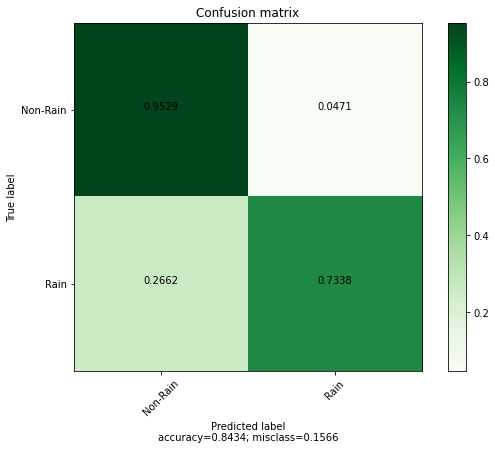

('Accuracy', 0.9312602291325696)
('Balanced Accuracy', 0.8433869101419333)
('f1', 0.678720445062587)
('f1-weighted', 0.9335323298223029)
('AUC', 0.8433869101419333)
('averagePrecision', 0.48960998279645973)
('precision', 0.6313065976714101)
('recall', 0.7338345864661654)
('g_mean', 0.838796614208908)

 RFC 



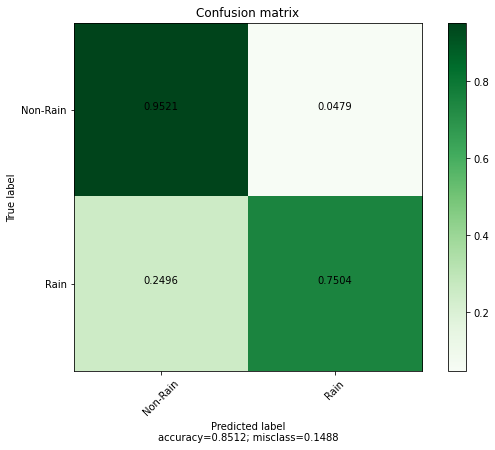

('Accuracy', 0.9321529534295492)
('Balanced Accuracy', 0.8512447730952215)
('f1', 0.686382393397524)
('f1-weighted', 0.9346951247211718)
('AUC', 0.8512447730952215)
('averagePrecision', 0.4992710680148675)
('precision', 0.632446134347275)
('recall', 0.750375939849624)
('g_mean', 0.8473910136866706)

 SVC 



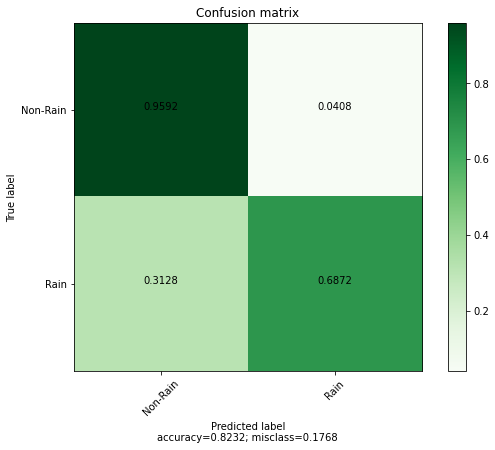

('Accuracy', 0.9323017408123792)
('Balanced Accuracy', 0.8232160238773949)
('f1', 0.6676406135865596)
('f1-weighted', 0.9331566885438302)
('AUC', 0.823216023877395)
('averagePrecision', 0.4770538077543957)
('precision', 0.6491477272727273)
('recall', 0.687218045112782)
('g_mean', 0.8159564500200291)

 KNN 



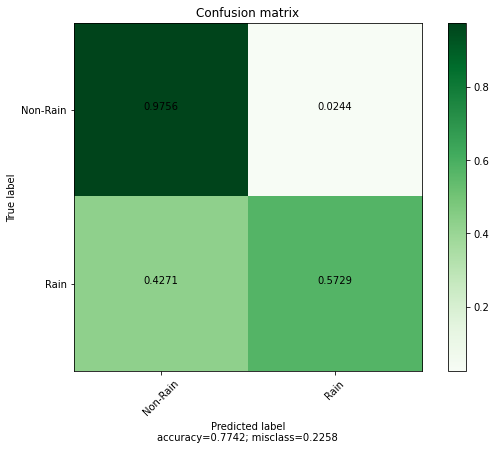

('Accuracy', 0.9357238506174677)
('Balanced Accuracy', 0.7742468787556738)
('f1', 0.6381909547738693)
('f1-weighted', 0.9324200888739398)
('AUC', 0.7742468787556739)
('averagePrecision', 0.4548968606653139)
('precision', 0.720226843100189)
('recall', 0.5729323308270676)
('g_mean', 0.7572208507570618)


In [ ]:
XGB_allknn, RFC_allknn, SVC_allknn, KNN_allknn = displayResults("ALL KNN", y_XGB_allknn, y_RFC_allknn, y_SVC_allknn, y_KNN_allknn)

One Sided Selection 

XGB 



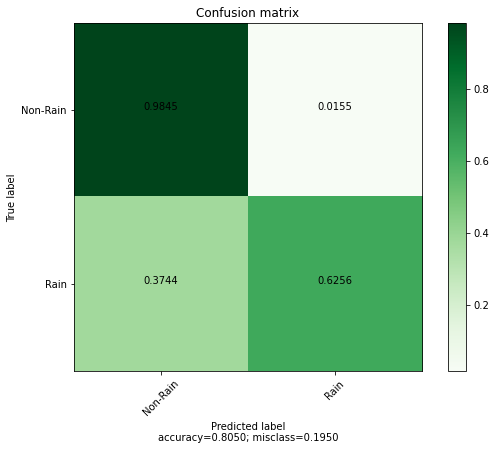

('Accuracy', 0.948965927689332)
('Balanced Accuracy', 0.8050210566045233)
('f1', 0.7080851063829787)
('f1-weighted', 0.945922271758584)
('AUC', 0.8050210566045233)
('averagePrecision', 0.547311953356351)
('precision', 0.8156862745098039)
('recall', 0.6255639097744361)
('g_mean', 0.7920472054524533)

 RFC 



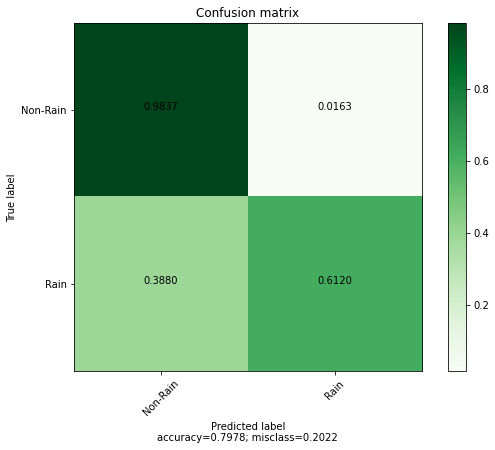

('Accuracy', 0.9468829043297129)
('Balanced Accuracy', 0.7978413255728489)
('f1', 0.695132365499573)
('f1-weighted', 0.9436208771376345)
('AUC', 0.7978413255728489)
('averagePrecision', 0.5306722052474037)
('precision', 0.8043478260869565)
('recall', 0.6120300751879699)
('g_mean', 0.7837967776110732)

 SVC 



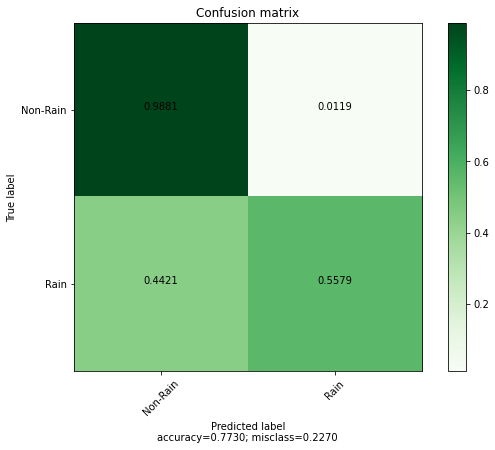

('Accuracy', 0.9455438178842435)
('Balanced Accuracy', 0.7730028505874991)
('f1', 0.6696750902527075)
('f1-weighted', 0.9405784491851839)
('AUC', 0.7730028505874992)
('averagePrecision', 0.5109645907064505)
('precision', 0.837471783295711)
('recall', 0.5578947368421052)
('g_mean', 0.7535005120241812)

 KNN 



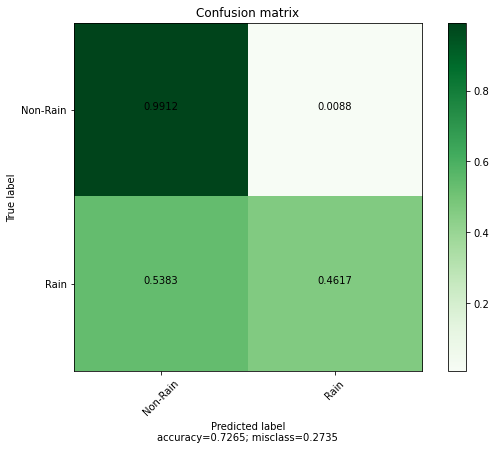

('Accuracy', 0.9388483856568963)
('Balanced Accuracy', 0.726451242041696)
('f1', 0.5990243902439024)
('f1-weighted', 0.9305012552227364)
('AUC', 0.726451242041696)
('averagePrecision', 0.4469542706888731)
('precision', 0.8527777777777777)
('recall', 0.4616541353383459)
('g_mean', 0.6947077518266417)


In [ ]:
XGB_OSS, RFC_OSS, SVC_OSS, KNN_OSS = displayResults("One Sided Selection", y_XGB_oss, y_RFC_oss,  y_SVC_oss,  y_KNN_oss)

Neighbourhood cleaning rule 

XGB 



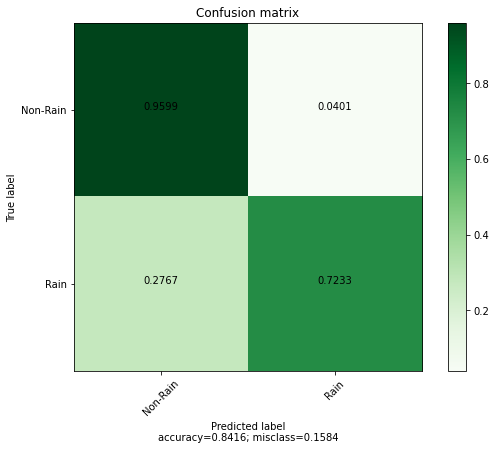

('Accuracy', 0.9364677875316173)
('Balanced Accuracy', 0.8415913876501028)
('f1', 0.6925845932325414)
('f1-weighted', 0.9376616072000521)
('AUC', 0.8415913876501028)
('averagePrecision', 0.5079173179372396)
('precision', 0.664364640883978)
('recall', 0.7233082706766917)
('g_mean', 0.8362263643968351)

 RFC 



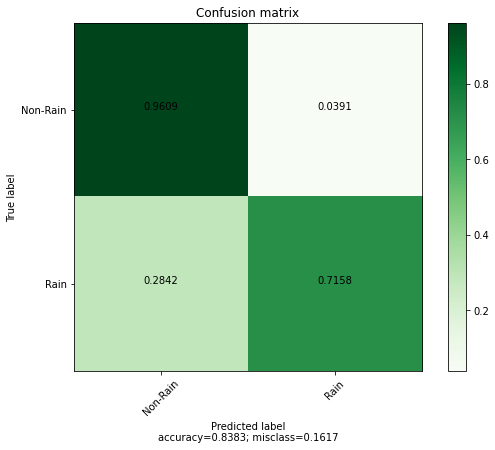

('Accuracy', 0.9366165749144473)
('Balanced Accuracy', 0.8383273656399917)
('f1', 0.690856313497823)
('f1-weighted', 0.9375944008882535)
('AUC', 0.8383273656399917)
('averagePrecision', 0.5059830726812032)
('precision', 0.667601683029453)
('recall', 0.7157894736842105)
('g_mean', 0.8325454962469562)

 SVC 



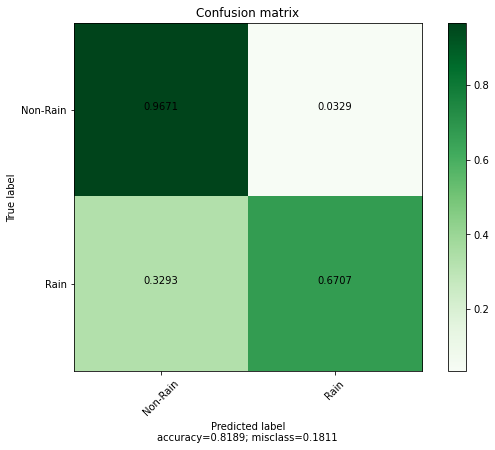

('Accuracy', 0.9378068739770867)
('Balanced Accuracy', 0.8189083590747013)
('f1', 0.6809160305343511)
('f1-weighted', 0.9373833809941611)
('AUC', 0.8189083590747013)
('averagePrecision', 0.4963391725161563)
('precision', 0.6914728682170542)
('recall', 0.6706766917293233)
('g_mean', 0.8102308582844936)

 KNN 



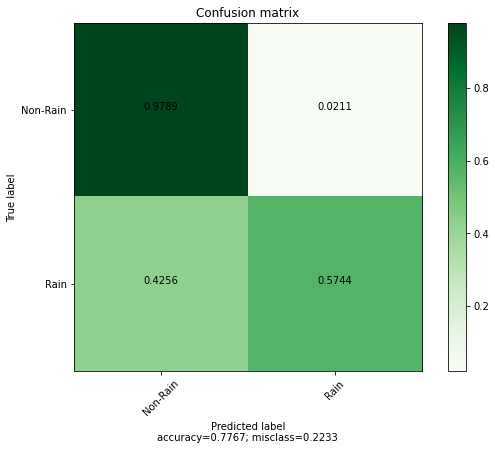

('Accuracy', 0.9388483856568963)
('Balanced Accuracy', 0.7766500134086869)
('f1', 0.6502127659574468)
('f1-weighted', 0.9352013227194695)
('AUC', 0.7766500134086869)
('averagePrecision', 0.4723707243725688)
('precision', 0.7490196078431373)
('recall', 0.5744360902255639)
('g_mean', 0.7595241479819748)


In [ ]:
XGB_ncr, RFC_ncr, SVC_ncr, KNN_ncr = displayResults("Neighbourhood cleaning rule", y_XGB_ncr, y_RFC_ncr,  y_SVC_ncr,  y_KNN_ncr)

Instance Hardness Threshold 

XGB 



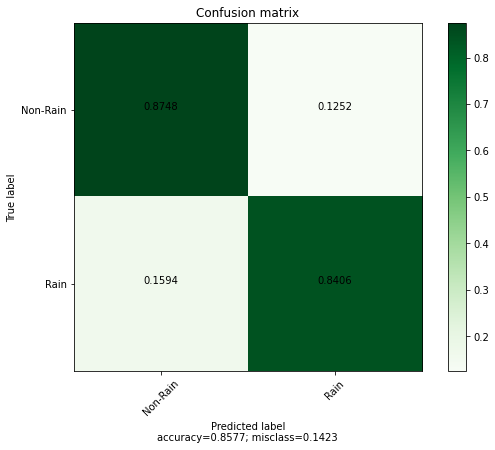

('Accuracy', 0.8714477012349353)
('Balanced Accuracy', 0.8577181891320109)
('f1', 0.5640766902119072)
('f1-weighted', 0.8889351269929645)
('AUC', 0.857718189132011)
('averagePrecision', 0.37256435597519244)
('precision', 0.42444950645406226)
('recall', 0.8406015037593985)
('g_mean', 0.857608297805771)

 RFC 



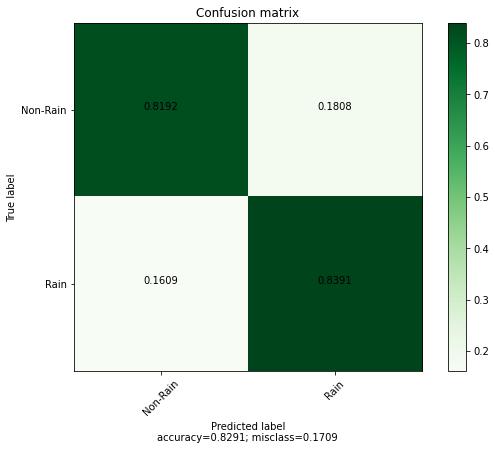

('Accuracy', 0.8211575658384169)
('Balanced Accuracy', 0.829142663461825)
('f1', 0.4814495254529767)
('f1-weighted', 0.8513294054555344)
('AUC', 0.8291426634618251)
('averagePrecision', 0.29917284606285366)
('precision', 0.33756805807622503)
('recall', 0.8390977443609022)
('g_mean', 0.8291042121401349)

 SVC 



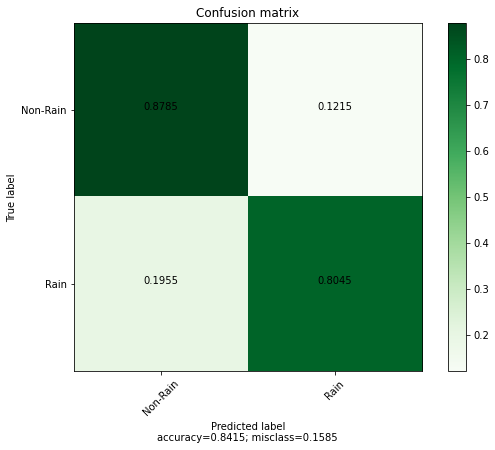

('Accuracy', 0.8711501264692754)
('Balanced Accuracy', 0.8414894567991975)
('f1', 0.5526859504132232)
('f1-weighted', 0.8879230528285634)
('AUC', 0.8414894567991974)
('averagePrecision', 0.3579840071593838)
('precision', 0.4209284028324154)
('recall', 0.8045112781954887)
('g_mean', 0.840966557348704)

 KNN 



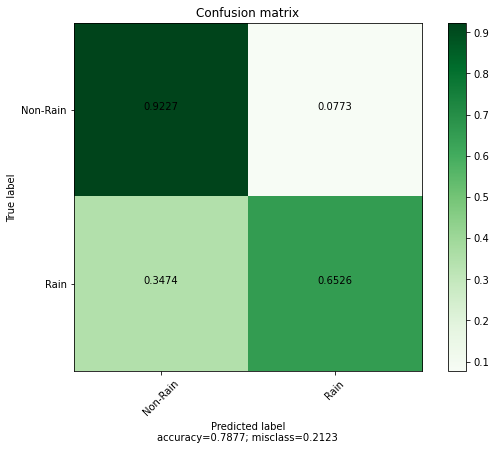

('Accuracy', 0.8959976194018747)
('Balanced Accuracy', 0.7876764235555864)
('f1', 0.5539246968730057)
('f1-weighted', 0.9028246747820298)
('AUC', 0.7876764235555865)
('averagePrecision', 0.34838552319774835)
('precision', 0.4811529933481153)
('recall', 0.6526315789473685)
('g_mean', 0.7801927112936583)


In [ ]:
XGB_iht, RFC_iht, SVC_iht, KNN_iht = displayResults("Instance Hardness Threshold", y_XGB_iht, y_RFC_iht, y_SVC_iht, y_KNN_iht)

OVERSAMPLING

RANDOM OVERSAMPLING 

XGB 



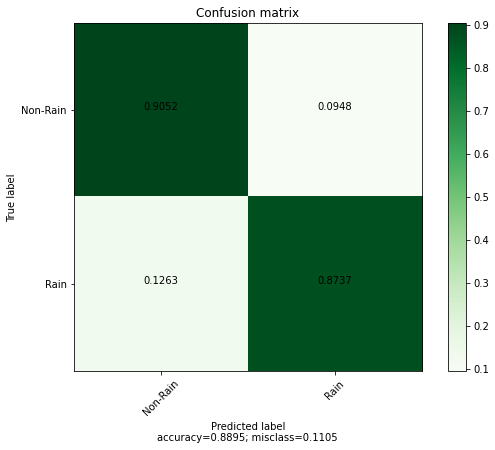

('Accuracy', 0.9020979020979021)
('Balanced Accuracy', 0.8894510880901064)
('f1', 0.6384615384615385)
('f1-weighted', 0.9132131850252657)
('AUC', 0.8894510880901065)
('averagePrecision', 0.4519877733315584)
('precision', 0.503030303030303)
('recall', 0.8736842105263158)
('g_mean', 0.8893611730900594)

 RFC 



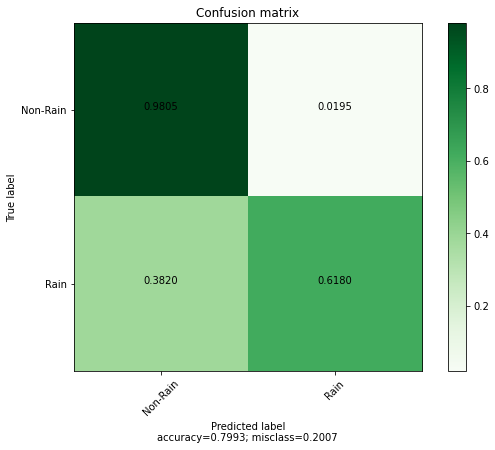

('Accuracy', 0.9446510935872638)
('Balanced Accuracy', 0.7992801521637647)
('f1', 0.6884422110552763)
('f1-weighted', 0.9418061876414481)
('AUC', 0.7992801521637648)
('averagePrecision', 0.5179744930712866)
('precision', 0.776937618147448)
('recall', 0.6180451127819548)
('g_mean', 0.7859491402327359)

 SVC 



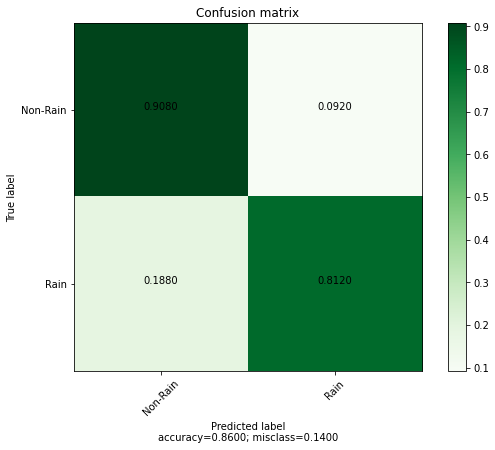

('Accuracy', 0.8985270049099836)
('Balanced Accuracy', 0.8600275871316336)
('f1', 0.6129398410896708)
('f1-weighted', 0.909089817818406)
('AUC', 0.8600275871316336)
('averagePrecision', 0.41832152276395507)
('precision', 0.49225159525979945)
('recall', 0.8120300751879699)
('g_mean', 0.8591654354419687)

 KNN 



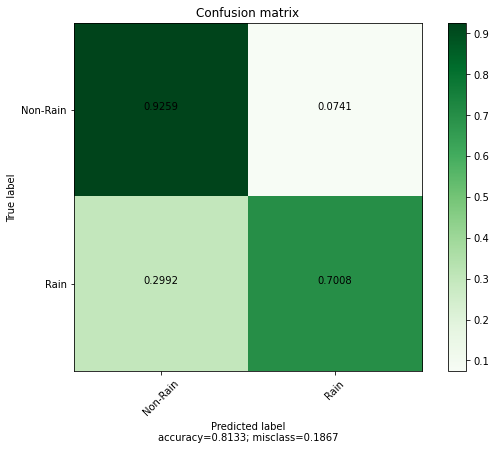

('Accuracy', 0.9035857759262015)
('Balanced Accuracy', 0.8133052661376029)
('f1', 0.589873417721519)
('f1-weighted', 0.9101974847064385)
('AUC', 0.8133052661376029)
('averagePrecision', 0.3864943459480203)
('precision', 0.5092896174863388)
('recall', 0.7007518796992481)
('g_mean', 0.8082789651348524)


In [ ]:
XGB_ROS, RFC_ROS, SVC_ROS, KNN_ROS = displayResults("RANDOM OVERSAMPLING", y_XGB_ros, y_RFC_ros, y_SVC_ros, y_KNN_ros)

SMOTE 

XGB 



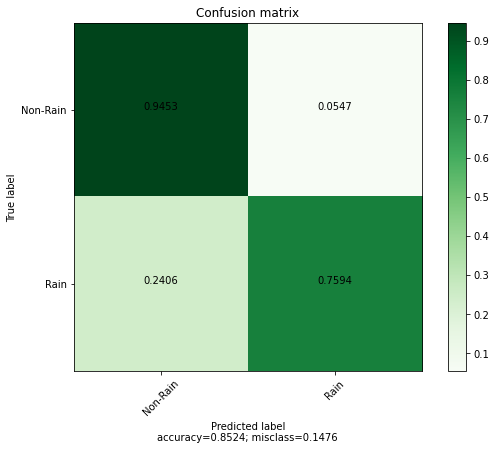

('Accuracy', 0.9269453950305014)
('Balanced Accuracy', 0.8523709786354923)
('f1', 0.6728847435043305)
('f1-weighted', 0.9305836473888447)
('AUC', 0.8523709786354924)
('averagePrecision', 0.4825335417809043)
('precision', 0.604066985645933)
('recall', 0.7593984962406015)
('g_mean', 0.8491024329486818)

 RFC 



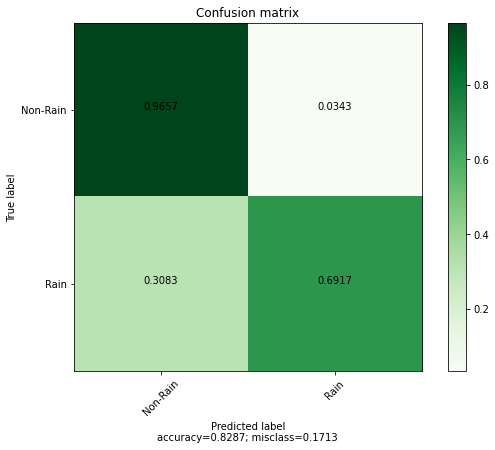

('Accuracy', 0.9385508108912364)
('Balanced Accuracy', 0.8286916101349808)
('f1', 0.6901725431357839)
('f1-weighted', 0.9386123465096415)
('AUC', 0.8286916101349808)
('averagePrecision', 0.5068419654588862)
('precision', 0.688622754491018)
('recall', 0.6917293233082706)
('g_mean', 0.8213773436839512)

 SVC 



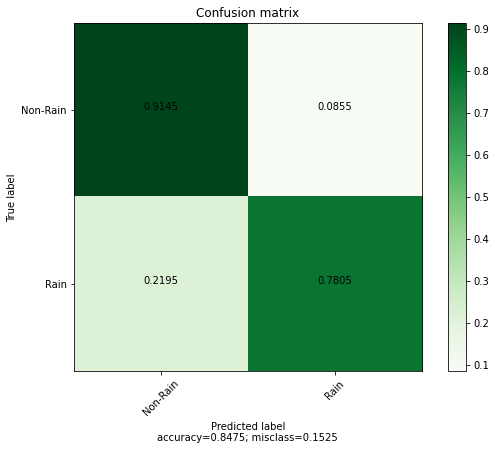

('Accuracy', 0.9012051778009225)
('Balanced Accuracy', 0.8474580606072646)
('f1', 0.6098707403055229)
('f1-weighted', 0.910436558614235)
('AUC', 0.8474580606072646)
('averagePrecision', 0.412324824178943)
('precision', 0.5004821600771456)
('recall', 0.7804511278195488)
('g_mean', 0.8457519801227763)

 KNN 



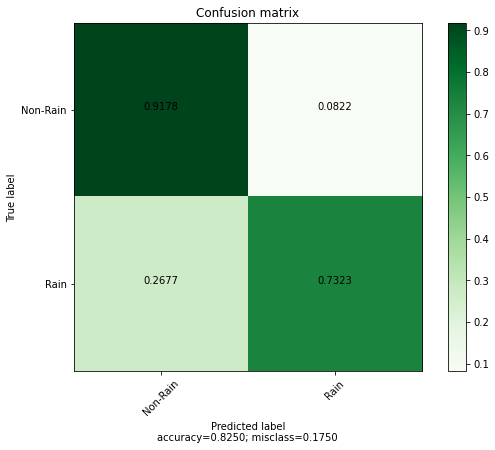

('Accuracy', 0.8994197292069632)
('Balanced Accuracy', 0.8250491651850895)
('f1', 0.5903030303030303)
('f1-weighted', 0.9078082420673144)
('AUC', 0.8250491651850895)
('averagePrecision', 0.3885604107751549)
('precision', 0.49441624365482234)
('recall', 0.7323308270676692)
('g_mean', 0.8216904186977487)


In [ ]:
XGB_SM, RFC_SM, SVC_SM, KNN_SM = displayResults("SMOTE", y_XGB_sm, y_RFC_sm, y_SVC_sm, y_KNN_sm)

BORDERLINE SMOTE 

XGB 



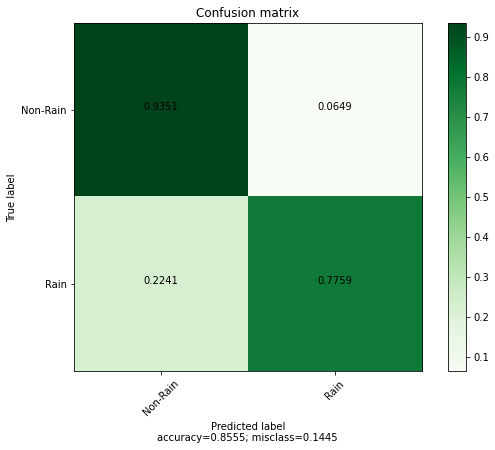

('Accuracy', 0.9193572385061747)
('Balanced Accuracy', 0.8555227649705506)
('f1', 0.6556543837357052)
('f1-weighted', 0.9247788341047587)
('AUC', 0.8555227649705507)
('averagePrecision', 0.4626368254388167)
('precision', 0.5676567656765676)
('recall', 0.7759398496240602)
('g_mean', 0.853137949789649)

 RFC 



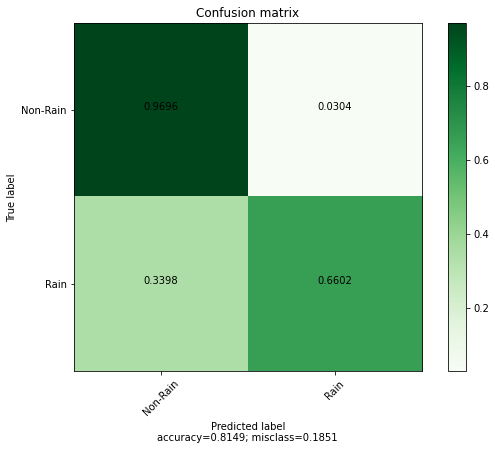

('Accuracy', 0.9389971730397262)
('Balanced Accuracy', 0.8148836423952881)
('f1', 0.6816770186335402)
('f1-weighted', 0.9381079640151203)
('AUC', 0.8148836423952882)
('averagePrecision', 0.4988041428014178)
('precision', 0.7046548956661316)
('recall', 0.6601503759398496)
('g_mean', 0.8053764226461958)

 SVC 



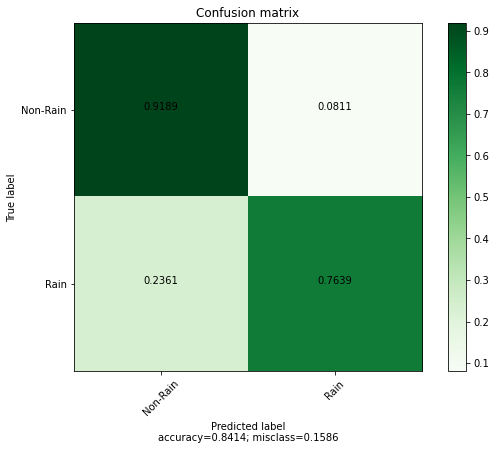

('Accuracy', 0.9035857759262015)
('Balanced Accuracy', 0.8414165781031178)
('f1', 0.6105769230769231)
('f1-weighted', 0.9118949079394176)
('AUC', 0.8414165781031179)
('averagePrecision', 0.41181423913786736)
('precision', 0.5085085085085085)
('recall', 0.7639097744360902)
('g_mean', 0.8391167074661273)

 KNN 



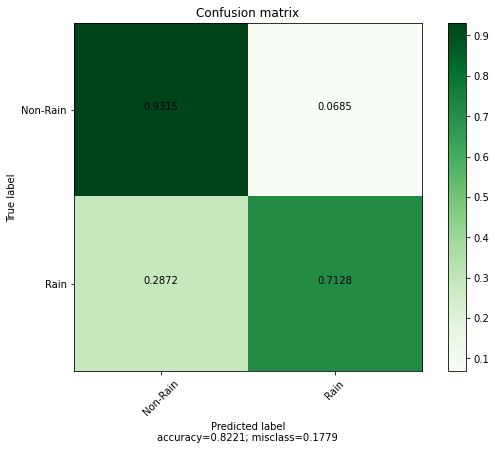

('Accuracy', 0.9098348460050588)
('Balanced Accuracy', 0.8221274371529881)
('f1', 0.61003861003861)
('f1-weighted', 0.9154837656598774)
('AUC', 0.8221274371529882)
('averagePrecision', 0.40846186213012564)
('precision', 0.5331833520809899)
('recall', 0.7127819548872181)
('g_mean', 0.8174355836102294)


In [ ]:
XGB_BSM, RFC_BSM, SVC_BSM, KNN_BSM = displayResults("BORDERLINE SMOTE", y_XGB_bsm, y_RFC_bsm, y_SVC_bsm,  y_KNN_bsm)

SVM SMOTE 

XGB 



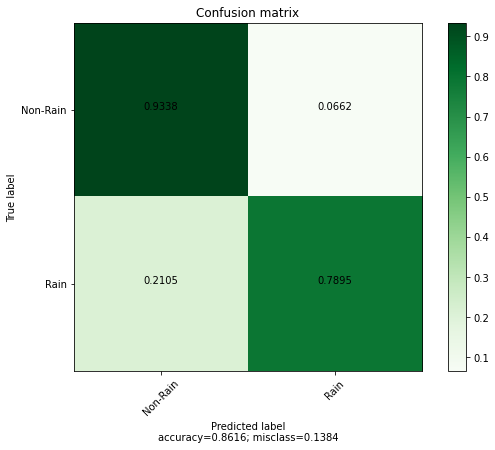

('Accuracy', 0.9195060258890047)
('Balanced Accuracy', 0.8616291802822778)
('f1', 0.6599622878692645)
('f1-weighted', 0.9252220764858448)
('AUC', 0.8616291802822776)
('averagePrecision', 0.46842600488185654)
('precision', 0.5669546436285097)
('recall', 0.7894736842105263)
('g_mean', 0.8596831480589374)

 RFC 



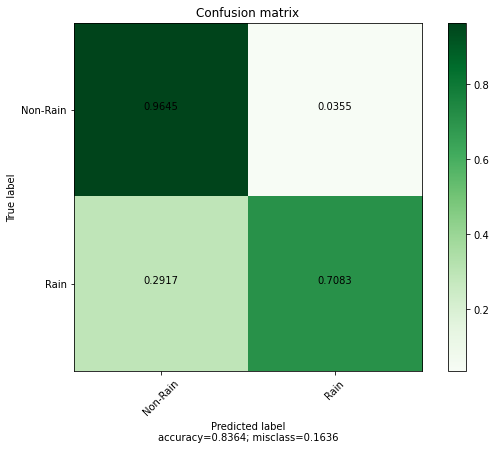

('Accuracy', 0.9391459604225562)
('Balanced Accuracy', 0.8363843475928924)
('f1', 0.6972612879348631)
('f1-weighted', 0.9395660727476112)
('AUC', 0.8363843475928923)
('averagePrecision', 0.51515555215502)
('precision', 0.6865889212827988)
('recall', 0.7082706766917293)
('g_mean', 0.830047485284447)

 SVC 



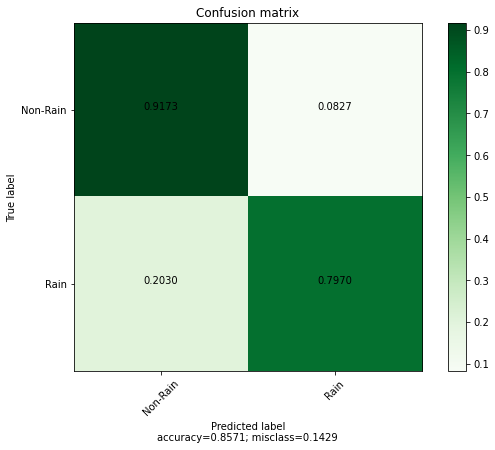

('Accuracy', 0.9053712245201607)
('Balanced Accuracy', 0.857132304009694)
('f1', 0.625)
('f1-weighted', 0.9141074639356535)
('AUC', 0.857132304009694)
('averagePrecision', 0.42979145190764173)
('precision', 0.5140640155189137)
('recall', 0.7969924812030075)
('g_mean', 0.8557737978724)

 KNN 



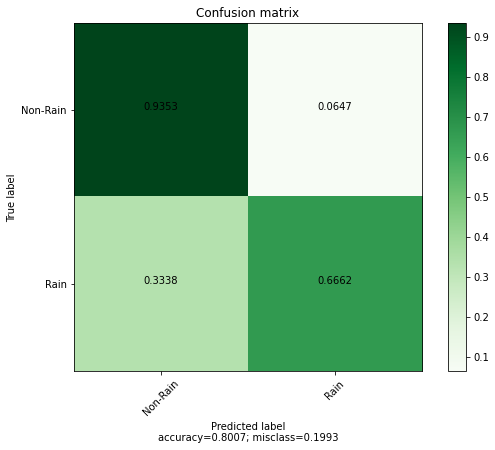

('Accuracy', 0.9086445469424193)
('Balanced Accuracy', 0.800718109673126)
('f1', 0.5906666666666667)
('f1-weighted', 0.9131711119773278)
('AUC', 0.800718109673126)
('averagePrecision', 0.386457479461885)
('precision', 0.5305389221556887)
('recall', 0.6661654135338346)
('g_mean', 0.7934112271053779)


In [ ]:
XGB_SVMSM, RFC_SVMSM, SVC_SVMSM, KNN_SVMSM = displayResults("SVM SMOTE", y_XGB_svmsm, y_RFC_svmsm, y_SVC_svmsm, y_KNN_svmsm)

ADASYN 

XGB 



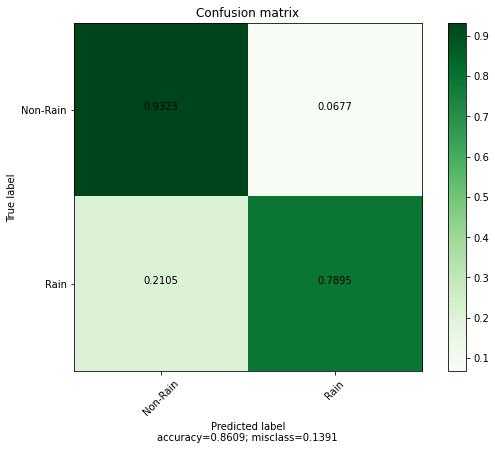

('Accuracy', 0.9181669394435352)
('Balanced Accuracy', 0.8608861155530836)
('f1', 0.65625)
('f1-weighted', 0.9241386987451528)
('AUC', 0.8608861155530836)
('averagePrecision', 0.4641175963881978)
('precision', 0.5614973262032086)
('recall', 0.7894736842105263)
('g_mean', 0.85897835314198)

 RFC 



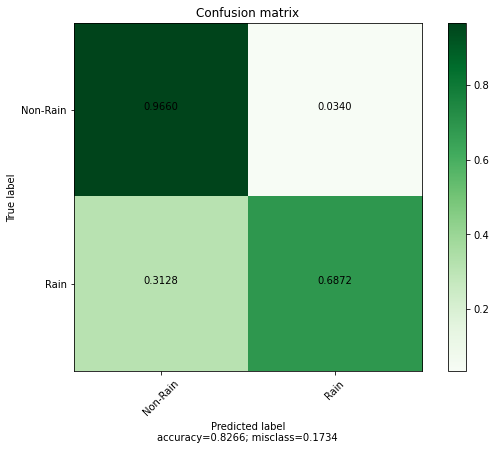

('Accuracy', 0.9384020235084065)
('Balanced Accuracy', 0.8266010965326129)
('f1', 0.6882530120481928)
('f1-weighted', 0.9383607243485154)
('AUC', 0.8266010965326128)
('averagePrecision', 0.5046410586098353)
('precision', 0.6892911010558069)
('recall', 0.687218045112782)
('g_mean', 0.8190054490150059)

 SVC 



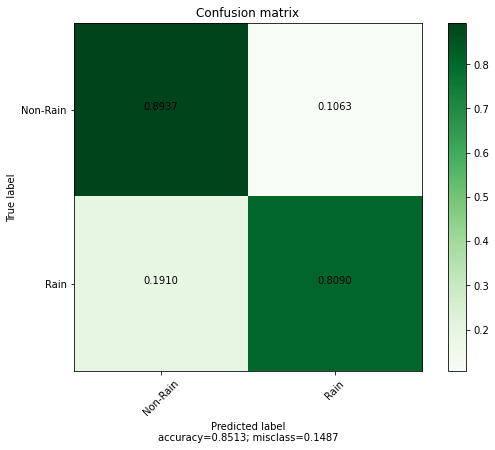

('Accuracy', 0.8852849278381193)
('Balanced Accuracy', 0.8513408686842602)
('f1', 0.5825663237682729)
('f1-weighted', 0.8987826008268309)
('AUC', 0.8513408686842602)
('averagePrecision', 0.38713130670429685)
('precision', 0.45516074450084604)
('recall', 0.8090225563909774)
('g_mean', 0.8506639028078187)

 KNN 



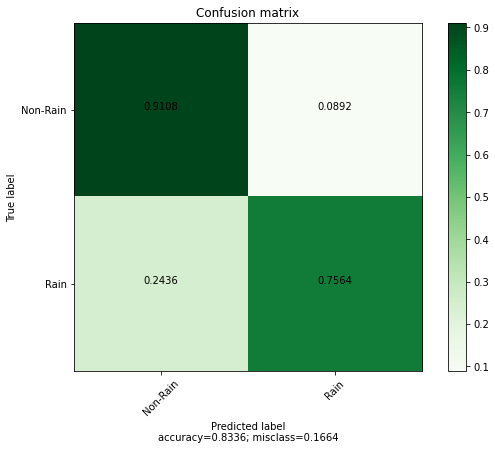

('Accuracy', 0.8955512572533849)
('Balanced Accuracy', 0.8336116049701533)
('f1', 0.5889929742388759)
('f1-weighted', 0.9054267499225076)
('AUC', 0.8336116049701534)
('averagePrecision', 0.38888271388435125)
('precision', 0.4822627037392138)
('recall', 0.7563909774436091)
('g_mean', 0.8313072761716616)


In [ ]:
XGB_ADA, RFC_ADA, SVC_ADA, KNN_ADA = displayResults("ADASYN", y_XGB_ada, y_RFC_ada, y_SVC_ada, y_KNN_ada)

**Over-Under Sampling**

SMOTE ENN 

XGB 



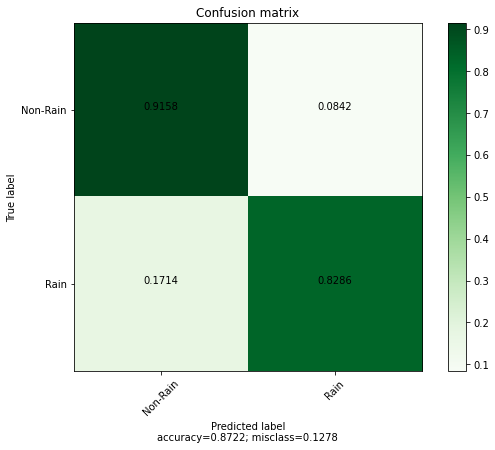

('Accuracy', 0.90715667311412)
('Balanced Accuracy', 0.8721787129647103)
('f1', 0.6384704519119351)
('f1-weighted', 0.9162382490441356)
('AUC', 0.8721787129647104)
('averagePrecision', 0.4472566317112811)
('precision', 0.5193213949104618)
('recall', 0.8285714285714286)
('g_mean', 0.87147705055989)

 RFC 



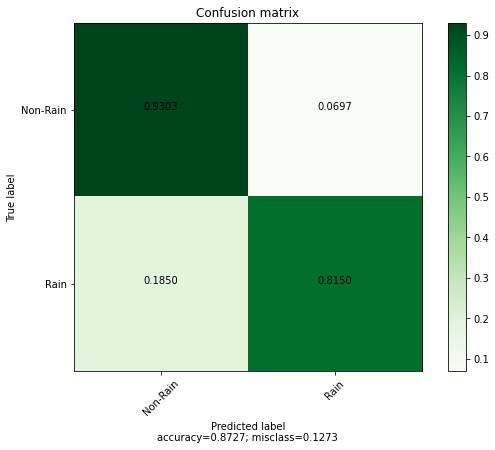

('Accuracy', 0.9189108763576849)
('Balanced Accuracy', 0.8726773174680427)
('f1', 0.665438919582566)
('f1-weighted', 0.9253265298814096)
('AUC', 0.8726773174680426)
('averagePrecision', 0.4765481260339843)
('precision', 0.5622406639004149)
('recall', 0.8150375939849624)
('g_mean', 0.8714517533722775)

 SVC 



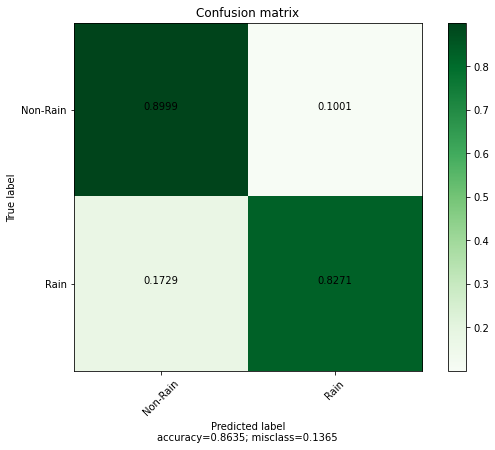

('Accuracy', 0.8927242969796161)
('Balanced Accuracy', 0.8635008094873908)
('f1', 0.6040637012630423)
('f1-weighted', 0.9049205238531071)
('AUC', 0.8635008094873907)
('averagePrecision', 0.4106116026976855)
('precision', 0.4757785467128028)
('recall', 0.8270676691729323)
('g_mean', 0.8630061620661644)

 KNN 



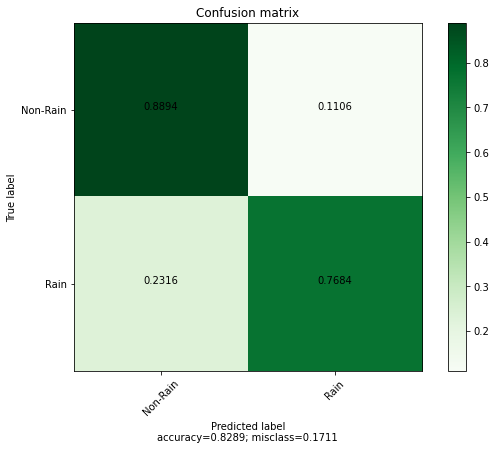

('Accuracy', 0.8773991965481327)
('Balanced Accuracy', 0.8288934853646666)
('f1', 0.5536294691224268)
('f1-weighted', 0.8918063351607288)
('AUC', 0.8288934853646667)
('averagePrecision', 0.35539687922061697)
('precision', 0.43268416596104997)
('recall', 0.7684210526315789)
('g_mean', 0.8274730243715325)


In [ ]:
XGB_SMOTE_ENN, RFC_SMOTE_ENN, SVC_SMOTE_ENN, KNN_SMOTE_ENN = displayResults("SMOTE ENN", y_XGB_smote_enn, y_RFC_smote_enn, y_SVC_smote_enn, y_KNN_smote_enn)

SMOTE TOMEK 

XGB 



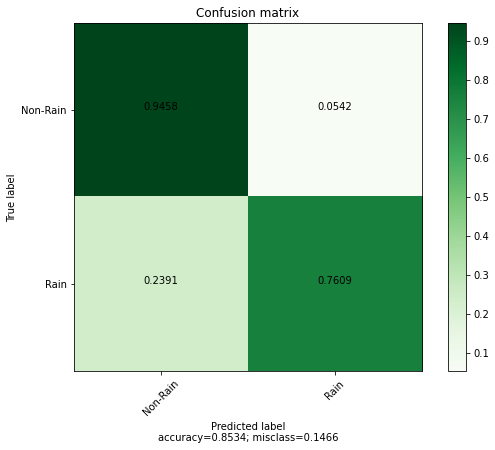

('Accuracy', 0.9275405445618211)
('Balanced Accuracy', 0.8533705465778052)
('f1', 0.6751167444963309)
('f1-weighted', 0.9311124797716567)
('AUC', 0.8533705465778051)
('averagePrecision', 0.48530772307065945)
('precision', 0.6067146282973621)
('recall', 0.7609022556390977)
('g_mean', 0.8501412242478028)

 RFC 



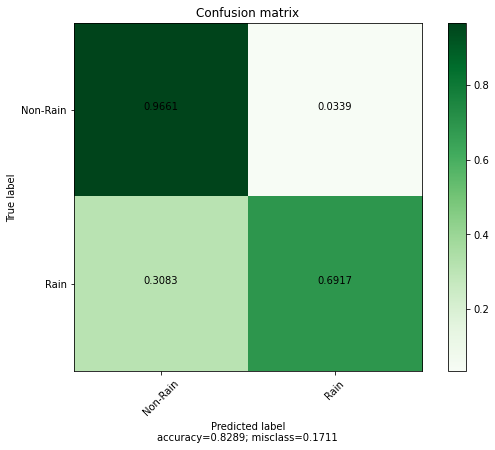

('Accuracy', 0.9389971730397262)
('Balanced Accuracy', 0.8289392983780455)
('f1', 0.6917293233082706)
('f1-weighted', 0.9389971730397262)
('AUC', 0.8289392983780454)
('averagePrecision', 0.5089908702046549)
('precision', 0.6917293233082706)
('recall', 0.6917293233082706)
('g_mean', 0.8216006478943648)

 SVC 



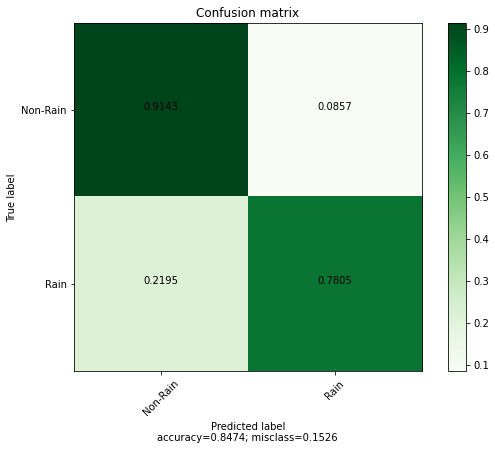

('Accuracy', 0.9010563904180926)
('Balanced Accuracy', 0.8473754978595762)
('f1', 0.6095126247798003)
('f1-weighted', 0.9103200265526086)
('AUC', 0.8473754978595763)
('averagePrecision', 0.41194852180294506)
('precision', 0.5)
('recall', 0.7804511278195488)
('g_mean', 0.8456734571611466)

 KNN 



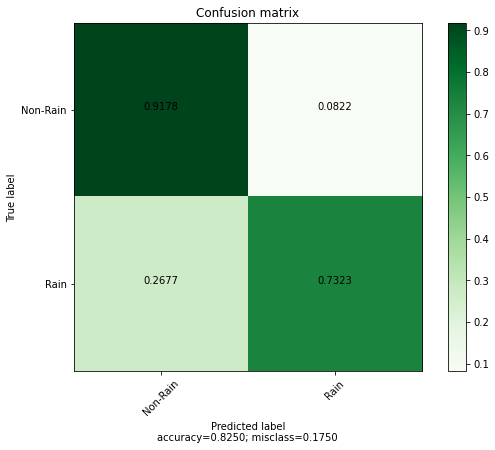

('Accuracy', 0.8994197292069632)
('Balanced Accuracy', 0.8250491651850895)
('f1', 0.5903030303030303)
('f1-weighted', 0.9078082420673144)
('AUC', 0.8250491651850895)
('averagePrecision', 0.3885604107751549)
('precision', 0.49441624365482234)
('recall', 0.7323308270676692)
('g_mean', 0.8216904186977487)


In [ ]:
XGB_SMOTE_TOMEK, RFC_SMOTE_TOMEK, SVC_SMOTE_TOMEK, KNN_SMOTE_TOMEK = displayResults("SMOTE TOMEK", y_XGB_smote_tomek, y_RFC_smote_tomek, y_SVC_smote_tomek, y_KNN_smote_tomek)

In [ ]:
undersampling_list_XGB = [XGB_normal, XGB_RUS, XGB_NM1, XGB_NM2, XGB_NM3, XGB_TL, XGB_ENN, XGB_RENN, XGB_allknn, XGB_OSS, XGB_ncr, XGB_iht]
undersampling_list_RFC = [RFC_normal, RFC_RUS, RFC_NM1, RFC_NM2, RFC_NM3, RFC_TL, RFC_ENN, RFC_RENN, RFC_allknn, RFC_OSS, RFC_ncr, RFC_iht]
undersampling_list_SVC = [SVC_normal, SVC_RUS, SVC_NM1, SVC_NM2, SVC_NM3, SVC_TL, SVC_ENN, SVC_RENN, SVC_allknn, SVC_OSS, SVC_ncr, SVC_iht]
undersampling_list_KNN = [KNN_normal, KNN_RUS, KNN_NM1, KNN_NM2, KNN_NM3, KNN_TL, KNN_ENN, KNN_RENN, KNN_allknn, KNN_OSS, KNN_ncr, KNN_iht]
undersamplingLists = undersampling_list_XGB + undersampling_list_RFC + undersampling_list_SVC + undersampling_list_KNN
undersampling_names = ["normal", "Random Undersampling", "NearMiss1", "NearMiss2", "NearMiss3", "Tomek's Links", "ENN", "RENN", "allknn", "One-Sided Selection", "neighbourhood cleaning rule", "instance hardness threshold"]

In [ ]:
oversampling_list_XGB = [XGB_normal, XGB_ROS, XGB_SM, XGB_BSM, XGB_SVMSM, XGB_ADA]
oversampling_list_RFC = [RFC_normal, RFC_ROS, RFC_SM, RFC_BSM, RFC_SVMSM, RFC_ADA]
oversampling_list_SVC = [SVC_normal, SVC_ROS, SVC_SM, SVC_BSM, SVC_SVMSM, SVC_ADA]
oversampling_list_KNN = [KNN_normal, KNN_ROS, KNN_SM, KNN_BSM, KNN_SVMSM, KNN_ADA]
oversamplingLists = oversampling_list_XGB + oversampling_list_RFC + oversampling_list_SVC + oversampling_list_KNN
oversampling_names = ["normal", "Random Oversampling", "SMOTE", "Borderline SMOTE", "SVM SMOTE", "ADASYN"]

In [ ]:
all_list_XGB = [XGB_normal, XGB_RUS, XGB_NM1, XGB_NM2, XGB_NM3, XGB_TL, XGB_ENN, XGB_RENN, XGB_allknn, XGB_OSS, XGB_ncr, XGB_iht, XGB_ROS, XGB_SM, XGB_BSM, XGB_SVMSM, XGB_ADA, XGB_SMOTE_ENN, XGB_SMOTE_TOMEK]
all_list_RFC = [RFC_normal, RFC_RUS, RFC_NM1, RFC_NM2, RFC_NM3, RFC_TL, RFC_ENN, RFC_RENN, RFC_allknn, RFC_OSS, RFC_ncr, RFC_iht, RFC_ROS, RFC_SM, RFC_BSM, RFC_SVMSM, RFC_ADA, RFC_SMOTE_ENN, RFC_SMOTE_TOMEK]
all_list_SVC = [SVC_normal, SVC_RUS, SVC_NM1, SVC_NM2, SVC_NM3, SVC_TL, SVC_ENN, SVC_RENN, SVC_allknn, SVC_OSS, SVC_ncr, SVC_iht, SVC_ROS, SVC_SM, SVC_BSM, SVC_SVMSM, SVC_ADA, SVC_SMOTE_ENN, SVC_SMOTE_TOMEK]
all_list_KNN = [KNN_normal, KNN_RUS, KNN_NM1, KNN_NM2, KNN_NM3, KNN_TL, KNN_ENN, KNN_RENN, KNN_allknn, KNN_OSS, KNN_ncr, KNN_iht, KNN_ROS, KNN_SM, KNN_BSM, KNN_SVMSM, KNN_ADA, KNN_SMOTE_ENN, KNN_SMOTE_TOMEK]
allLists = all_list_XGB + all_list_RFC + all_list_SVC + all_list_KNN
all_sampling_names = ["normal", "Random Undersampling", "NearMiss1", "NearMiss2", "NearMiss3", "Tomek's Links", "ENN", "RENN", "allknn", "One-Sided Selection", "neighbourhood cleaning rule", "instance hardness threshold","Random Oversampling", "SMOTE", "Borderline SMOTE", "SVM SMOTE", "ADASYN", "SMOTE-ENN", "SMOTE-TOMEK" ]

In [ ]:
metricNamesDF = ['Accuracy', 'Balanced Accuracy','f1','f1-weighted','AUC','averagePrecision','precision', 'recall', 'g_mean','Estimator']

In [ ]:
undersample_df = pd.DataFrame(columns=metricNamesDF, index=range(0,len(undersamplingLists)))

In [ ]:
oversample_df = pd.DataFrame(columns=metricNamesDF, index=range(0,len(oversamplingLists)))

In [ ]:
allsample_df = pd.DataFrame(columns=metricNamesDF, index=range(0,len(allLists)))

In [ ]:
for n,i in enumerate(undersamplingLists):
  undersample_df.iloc[n] = i

In [ ]:
for n,i in enumerate(oversamplingLists):
  oversample_df.iloc[n] = i

In [ ]:
for n,i in enumerate(allLists):
  allsample_df.iloc[n] = i

In [ ]:
undersample_df["Sampling Name"] = undersampling_names*4

In [ ]:
oversample_df["Sampling Name"] = oversampling_names*4

In [ ]:
allsample_df["Sampling Name"] = all_sampling_names*4

In [ ]:
undersample_df

,Accuracy,Balanced Accuracy,f1,f1-weighted,AUC,averagePrecision,precision,recall,g_mean,Estimator,Sampling Name
0,0.949859,0.798154,0.70619,0.946232,0.798154,0.550415,0.840249,0.609023,0.783604,XGB,normal
1,0.946883,0.815244,0.708095,0.944792,0.815244,0.539785,0.775986,0.651128,0.804545,XGB,Random Undersampling
2,0.943014,0.814436,0.694334,0.941443,0.814436,0.518148,0.739796,0.654135,0.804222,XGB,NearMiss1
3,0.866538,0.816173,0.527646,0.883243,0.816173,0.330272,0.405997,0.753383,0.814618,XGB,NearMiss2
4,0.946288,0.812236,0.703856,0.944086,0.812236,0.534669,0.774368,0.645113,0.801098,XGB,NearMiss3
5,0.948966,0.803682,0.707088,0.945832,0.803682,0.54671,0.818182,0.622556,0.790442,XGB,Tomek's Links
6,0.934534,0.836502,0.683453,0.935784,0.836502,0.49625,0.655172,0.714286,0.830738,XGB,ENN
7,0.925606,0.850959,0.668435,0.929442,0.850959,0.477073,0.597865,0.757895,0.847678,XGB,RENN
8,0.93126,0.843387,0.67872,0.933532,0.843387,0.48961,0.631307,0.733835,0.838797,XGB,allknn
9,0.948966,0.805021,0.708085,0.945922,0.805021,0.547312,0.815686,0.625564,0.792047,XGB,One-Sided Selection


In [ ]:
oversample_df

,Accuracy,Balanced Accuracy,f1,f1-weighted,AUC,averagePrecision,precision,recall,g_mean,Estimator,Sampling Name
0,0.949859,0.798154,0.70619,0.946232,0.798154,0.550415,0.840249,0.609023,0.783604,XGB,normal
1,0.902098,0.889451,0.638462,0.913213,0.889451,0.451988,0.50303,0.873684,0.889361,XGB,Random Oversampling
2,0.926945,0.852371,0.672885,0.930584,0.852371,0.482534,0.604067,0.759398,0.849102,XGB,SMOTE
3,0.919357,0.855523,0.655654,0.924779,0.855523,0.462637,0.567657,0.77594,0.853138,XGB,Borderline SMOTE
4,0.919506,0.861629,0.659962,0.925222,0.861629,0.468426,0.566955,0.789474,0.859683,XGB,SVM SMOTE
5,0.918167,0.860886,0.65625,0.924139,0.860886,0.464118,0.561497,0.789474,0.858978,XGB,ADASYN
6,0.94852,0.792056,0.696491,0.944627,0.792056,0.538835,0.835789,0.596992,0.776449,RFC,normal
7,0.944651,0.79928,0.688442,0.941806,0.79928,0.517974,0.776938,0.618045,0.785949,RFC,Random Oversampling
8,0.938551,0.828692,0.690173,0.938612,0.828692,0.506842,0.688623,0.691729,0.821377,RFC,SMOTE
9,0.938997,0.814884,0.681677,0.938108,0.814884,0.498804,0.704655,0.66015,0.805376,RFC,Borderline SMOTE


### Undersampling Results

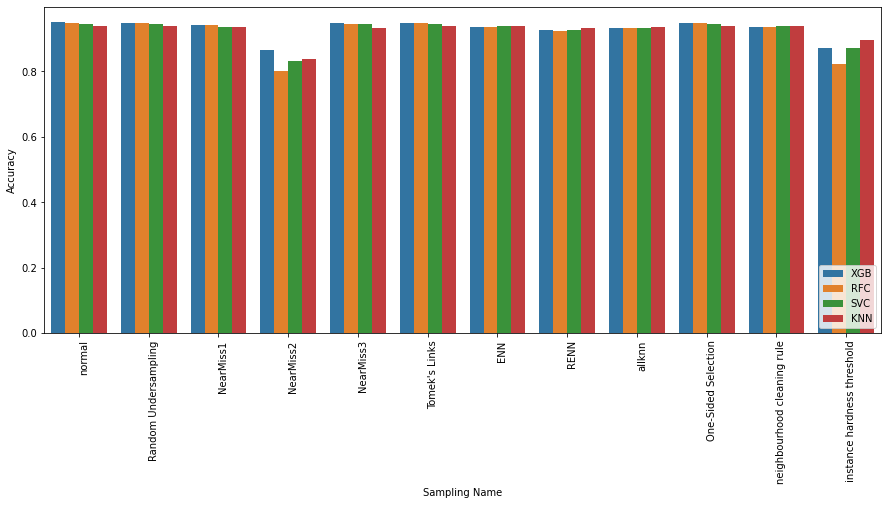

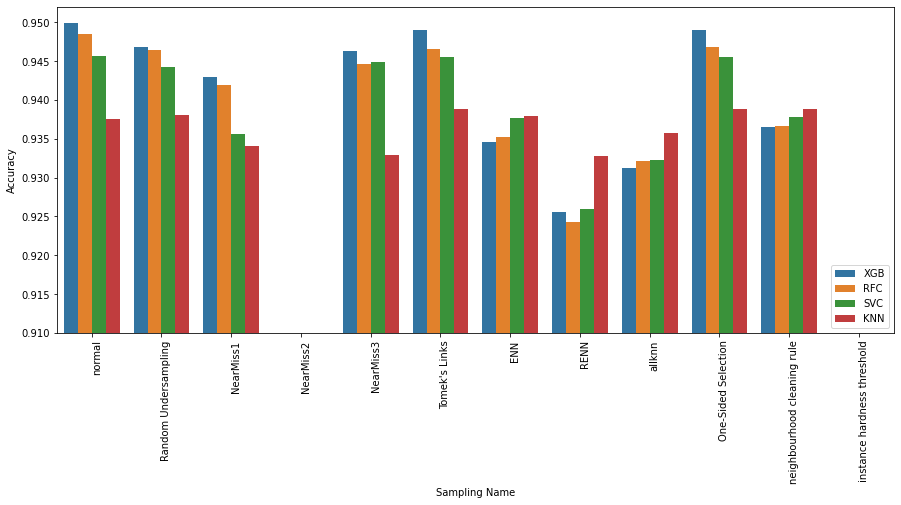

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.91,0.952)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

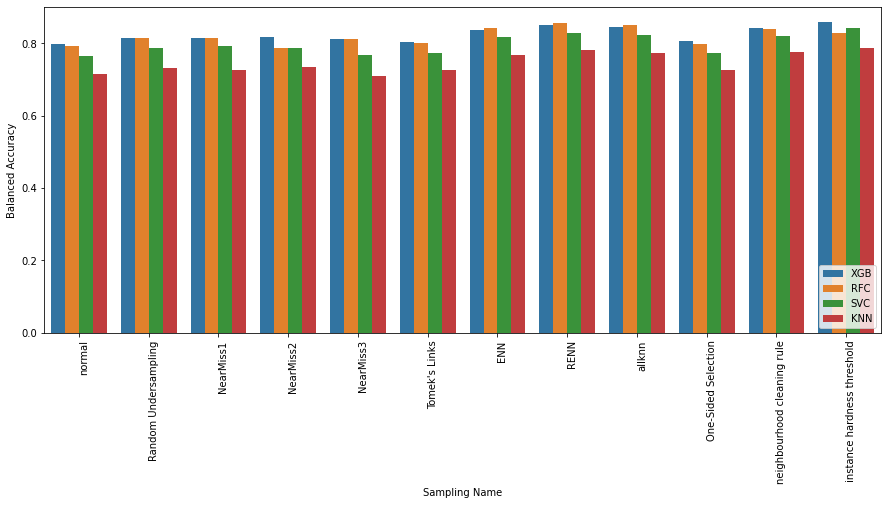

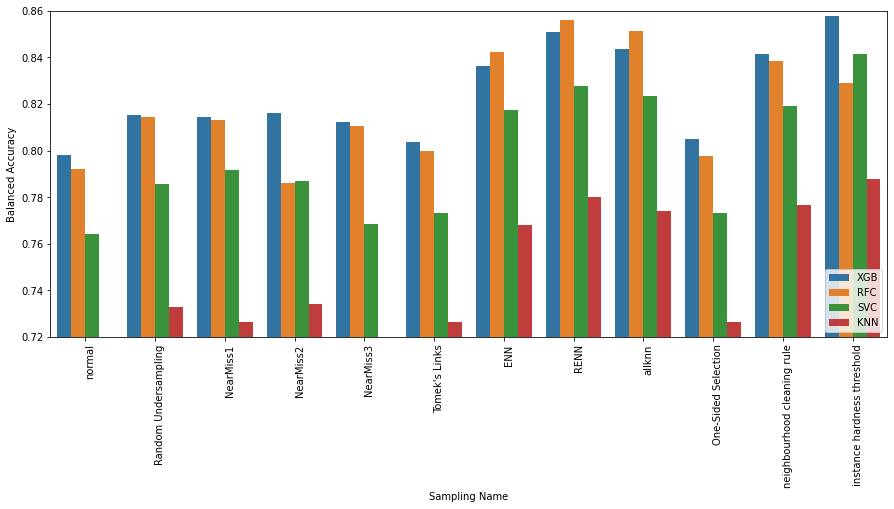

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.72,0.86)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

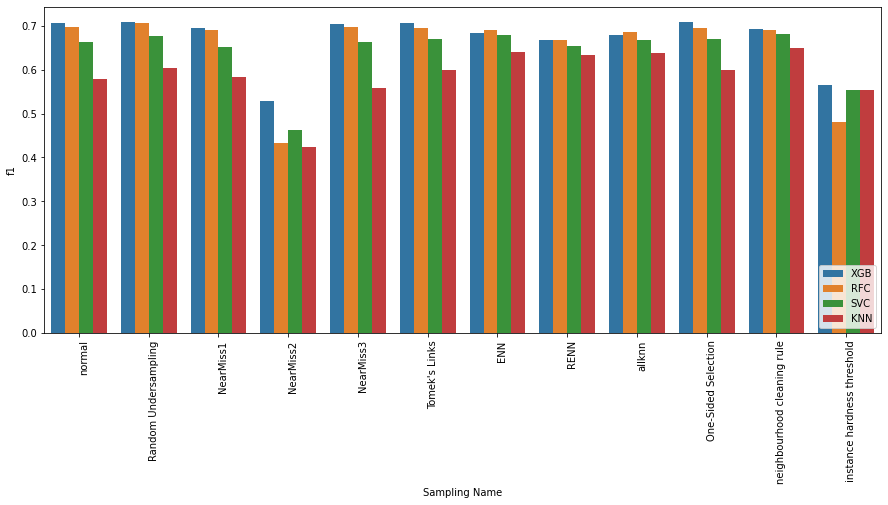

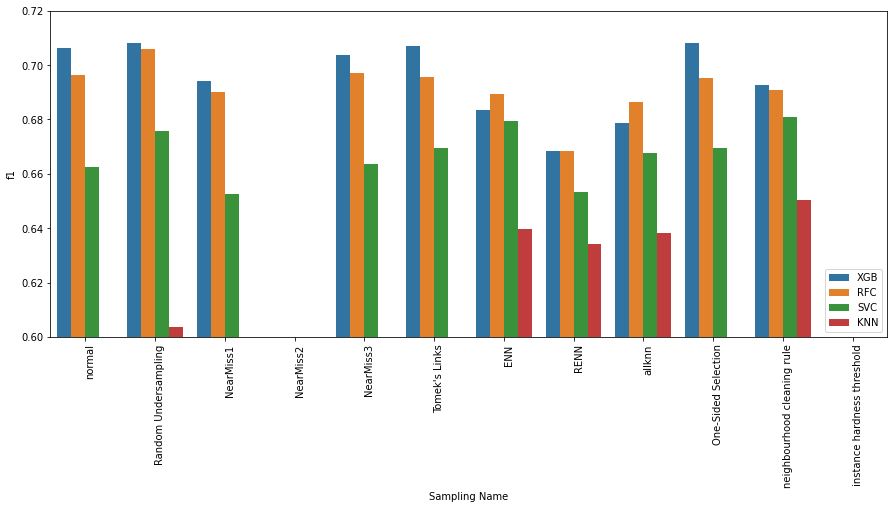

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.60,0.72)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

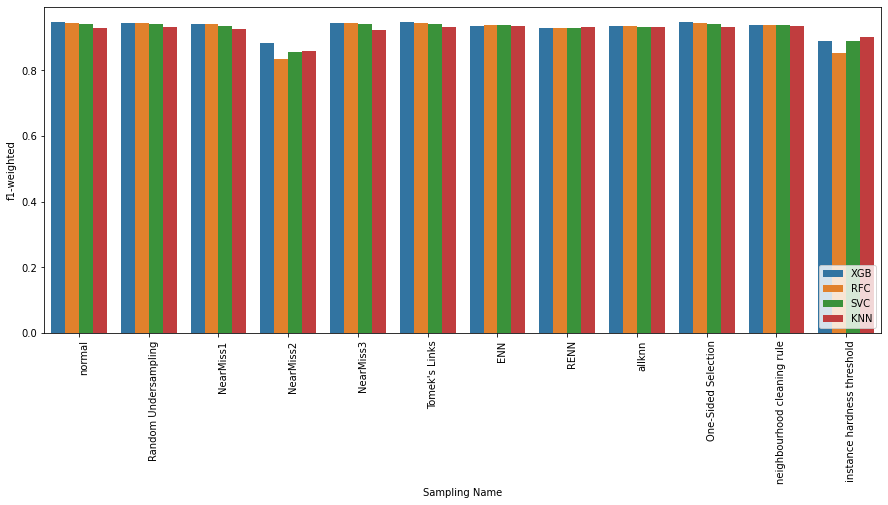

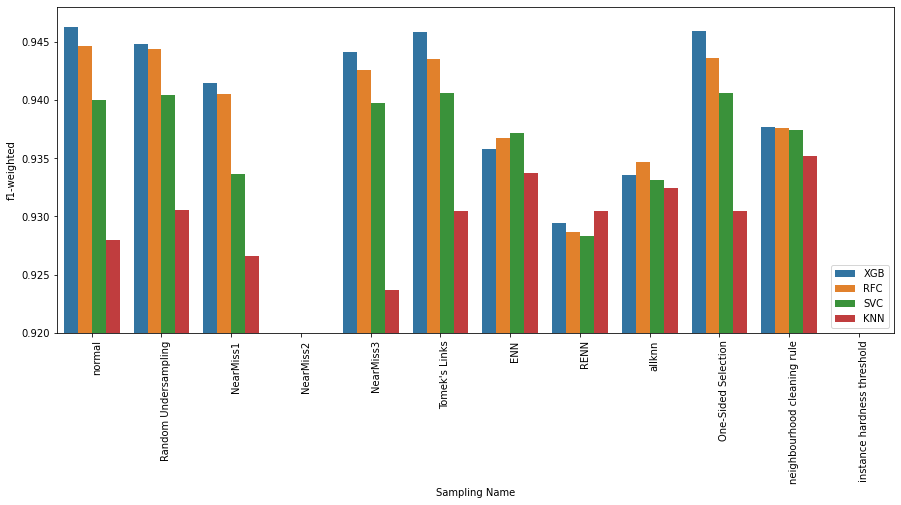

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.92,0.948)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

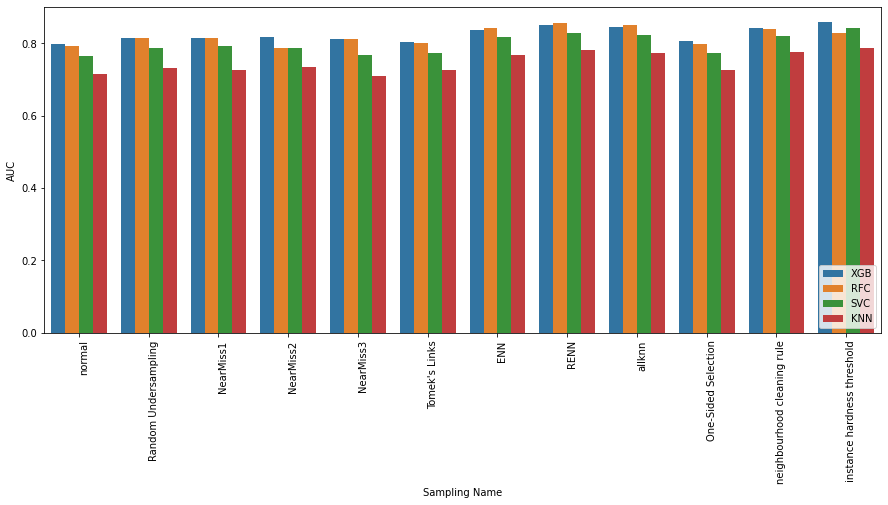

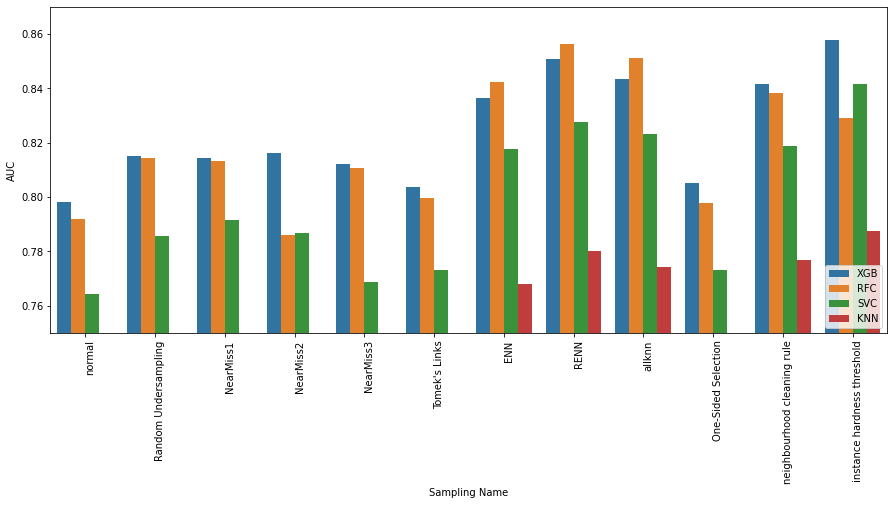

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.75,0.87)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

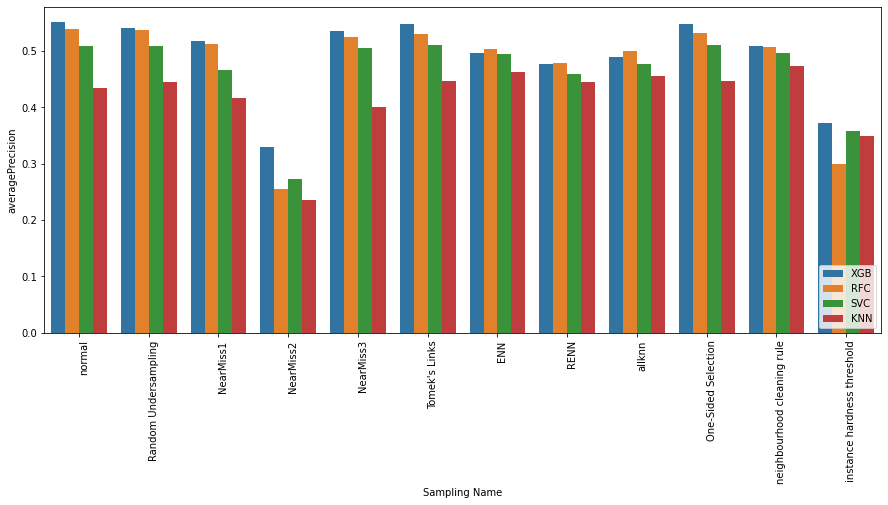

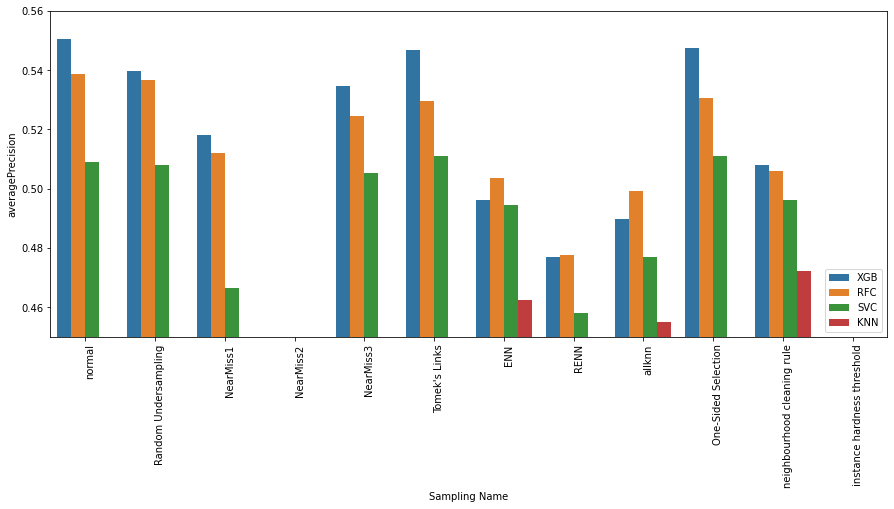

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="averagePrecision", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.45,0.56)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="averagePrecision", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

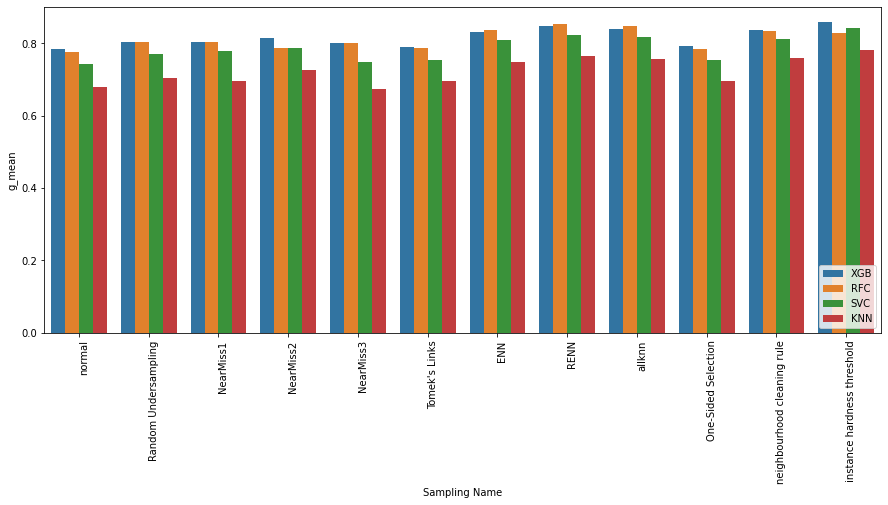

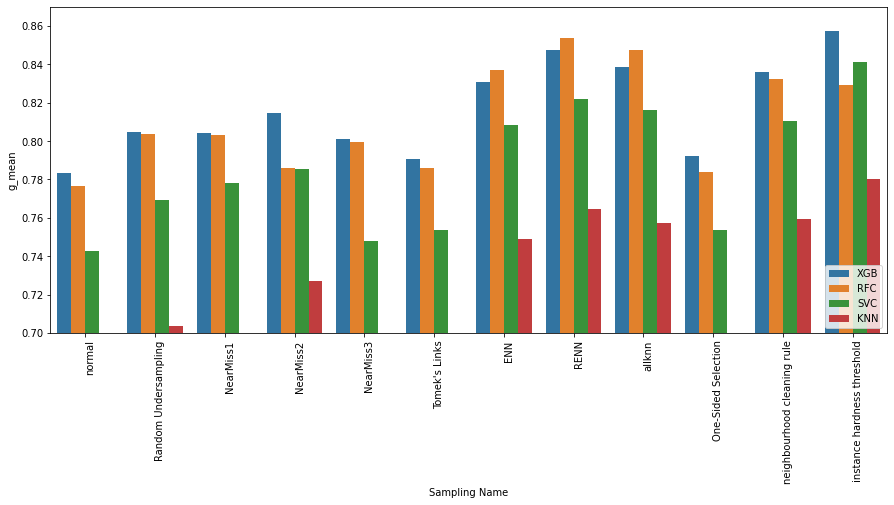

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = undersample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.7,0.87)
ax1.set_xticklabels(rotation = 90, labels=undersample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = undersample_df, hue="Estimator",);
plt.legend(loc='lower right');

### Oversampling Results

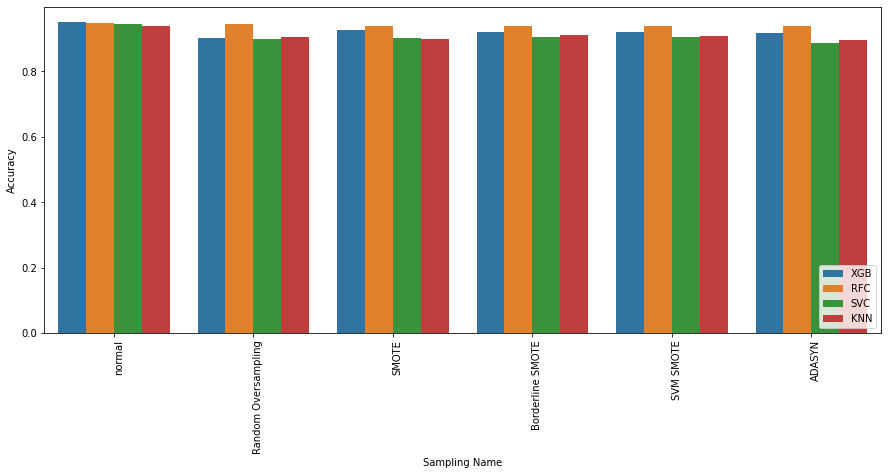

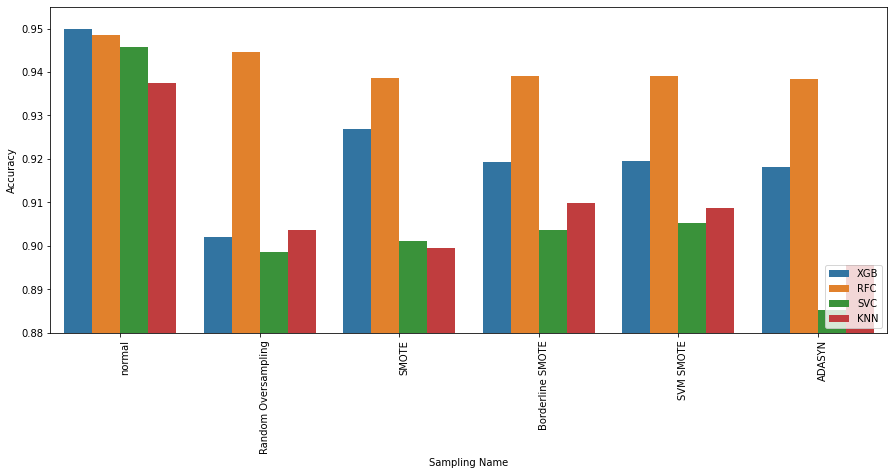

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.88,0.955)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

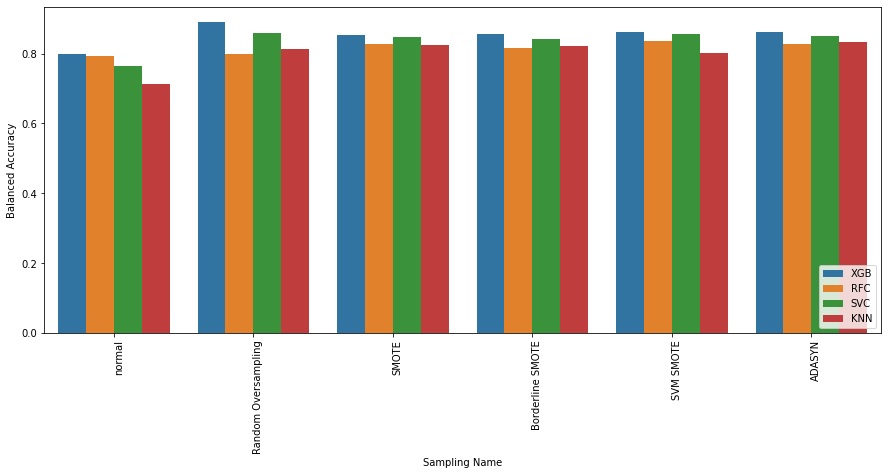

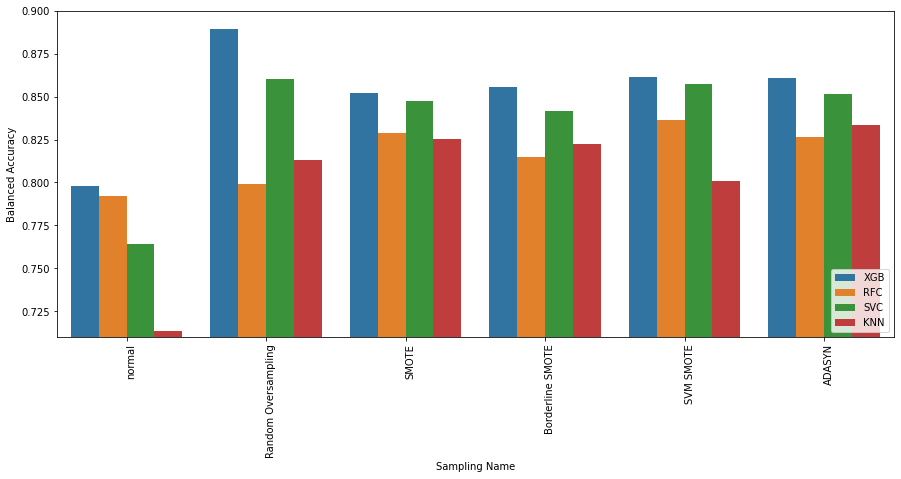

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.71,0.90)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

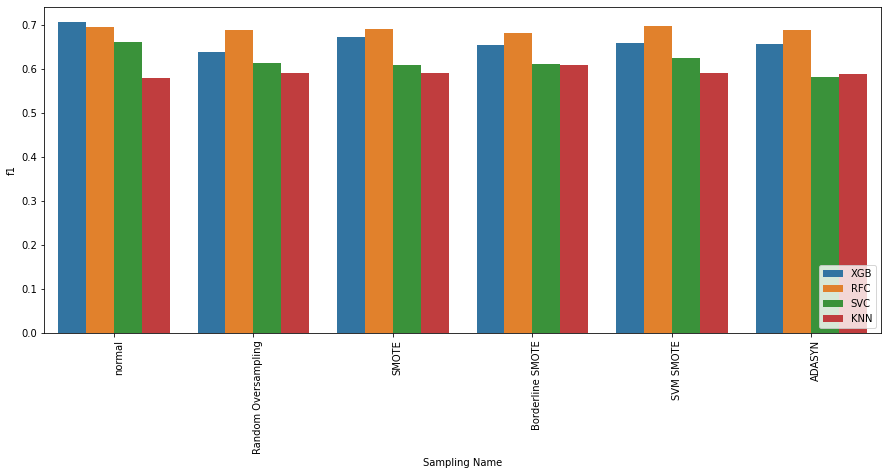

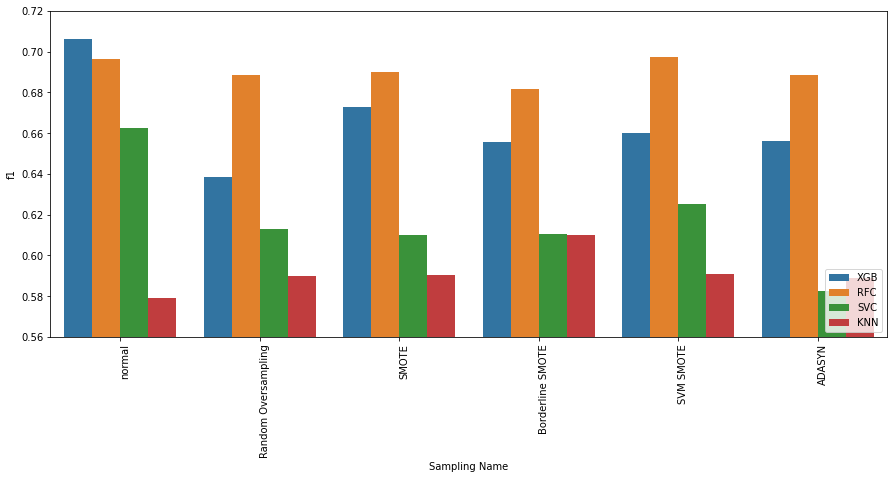

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.56,0.72)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

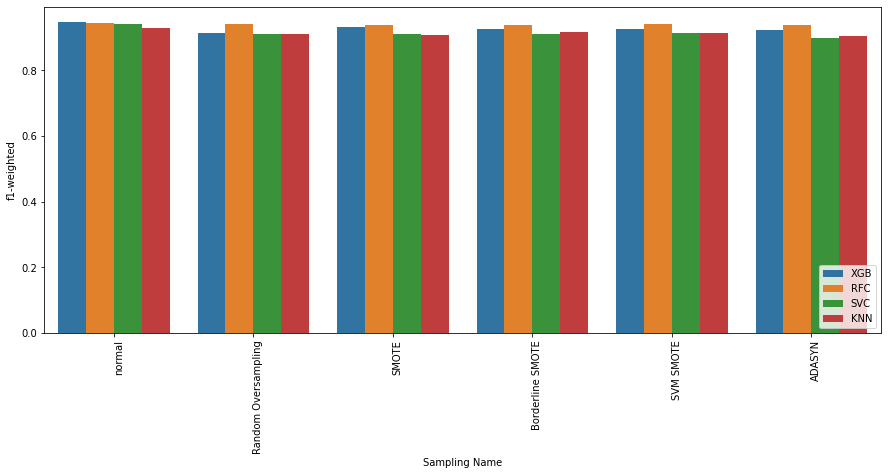

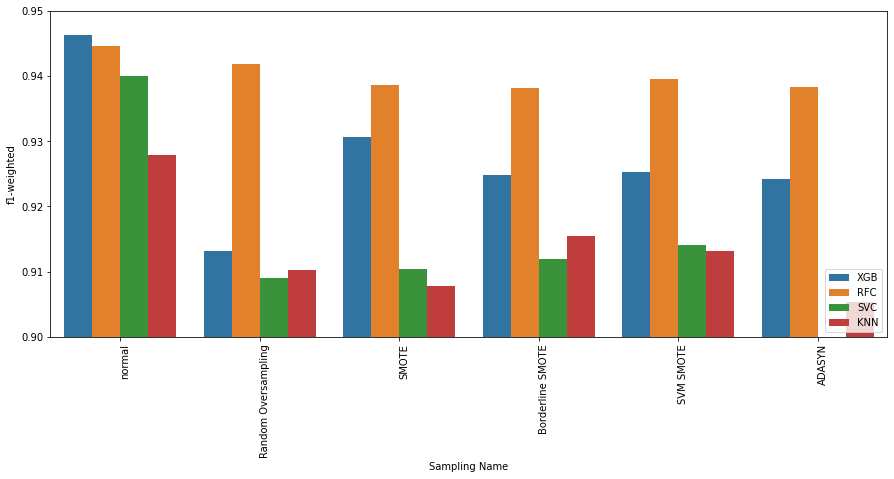

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.90,0.95)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

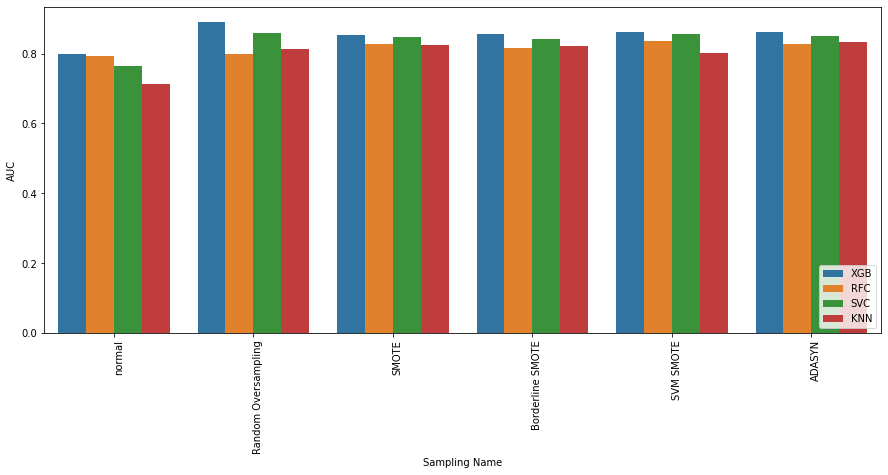

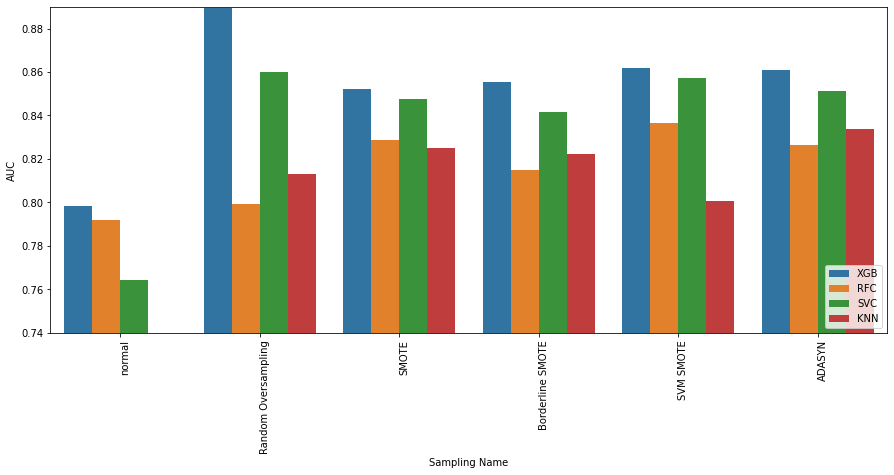

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.74,0.89)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

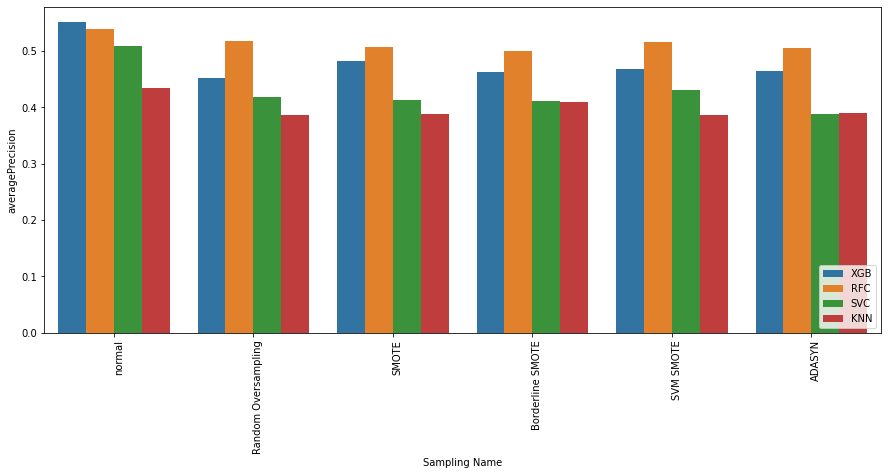

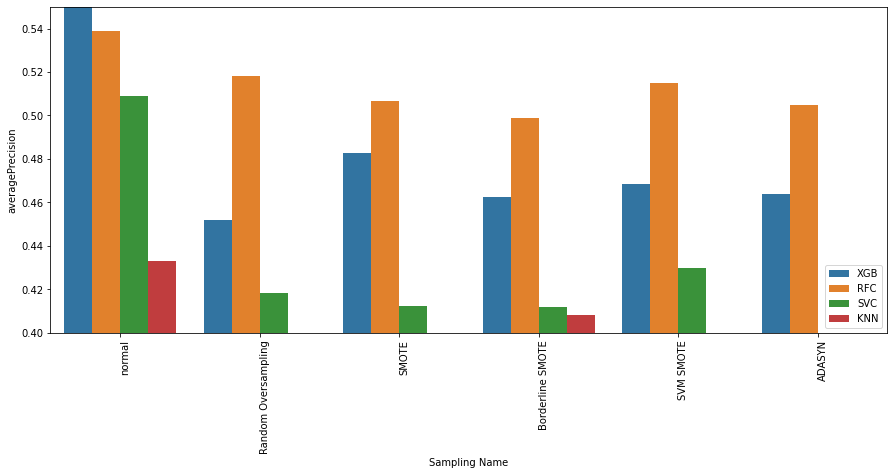

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="averagePrecision", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.4,0.55)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="averagePrecision", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

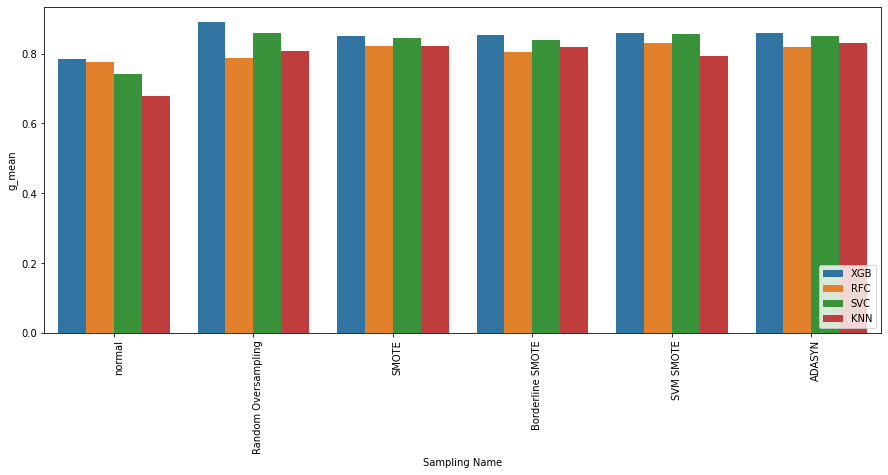

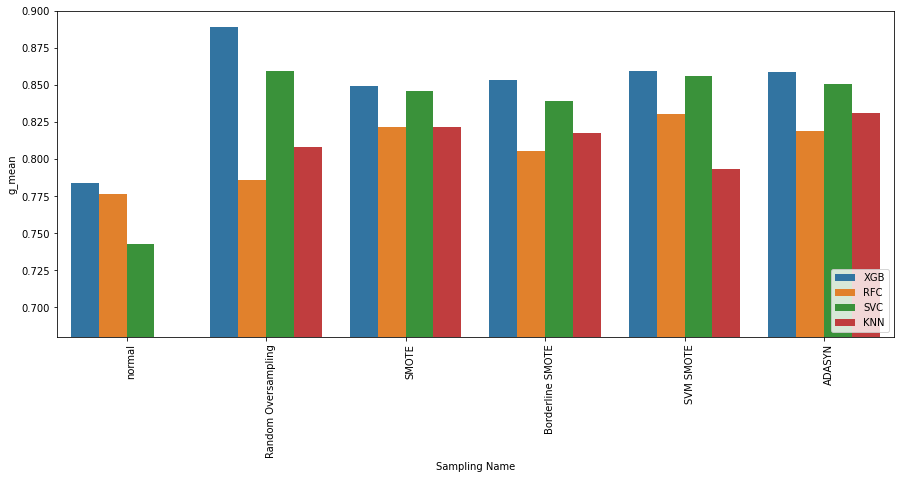

In [ ]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = oversample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_ylim(0.68,0.90)
ax1.set_xticklabels(rotation = 90, labels=oversample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = oversample_df, hue="Estimator",);
plt.legend(loc='lower right');

### Combined Results

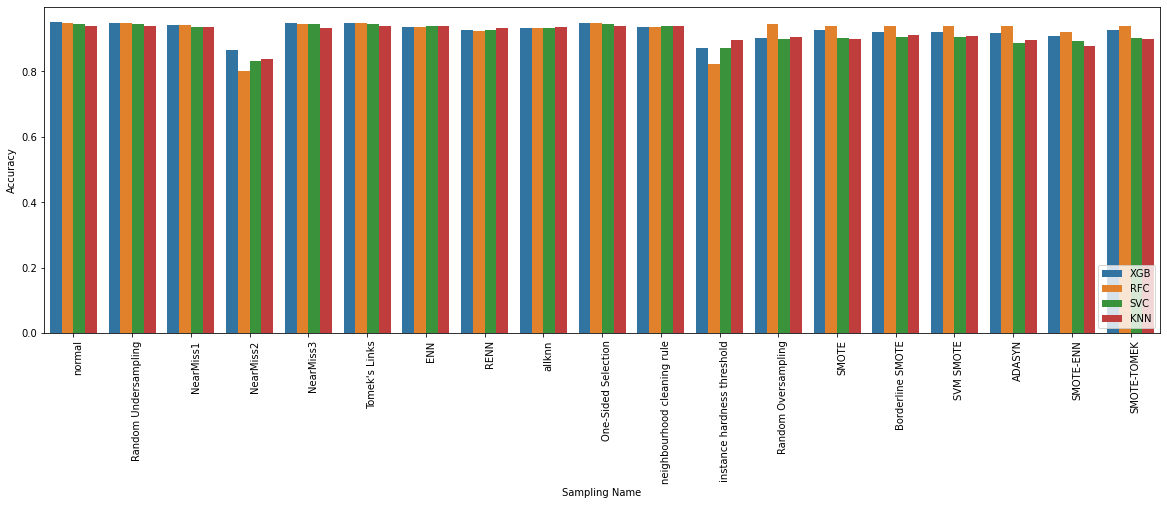

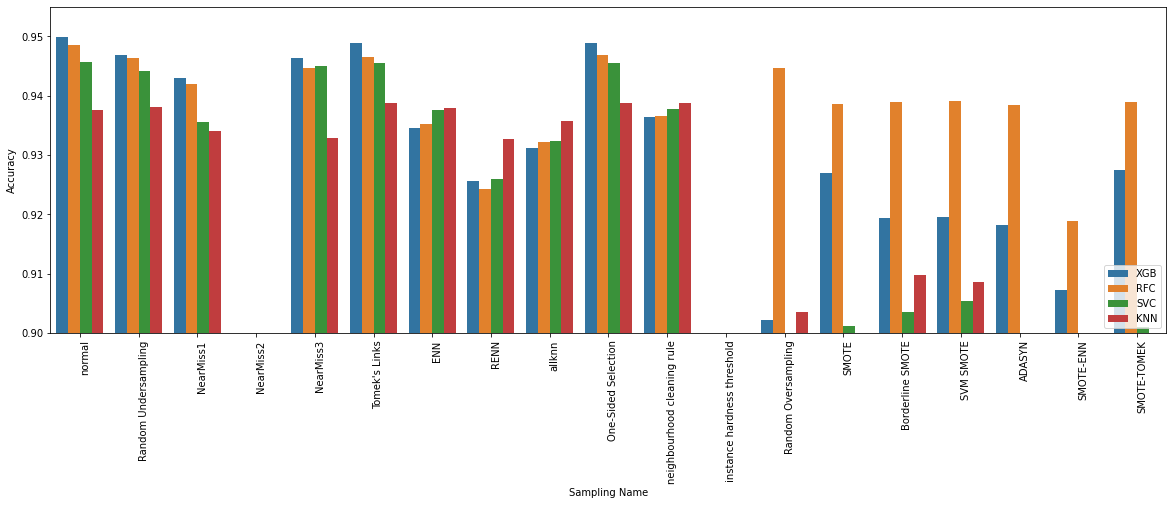

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = allsample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_ylim(0.9,0.955)
ax1.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Accuracy", data = allsample_df, hue="Estimator",);
plt.legend(loc='lower right');

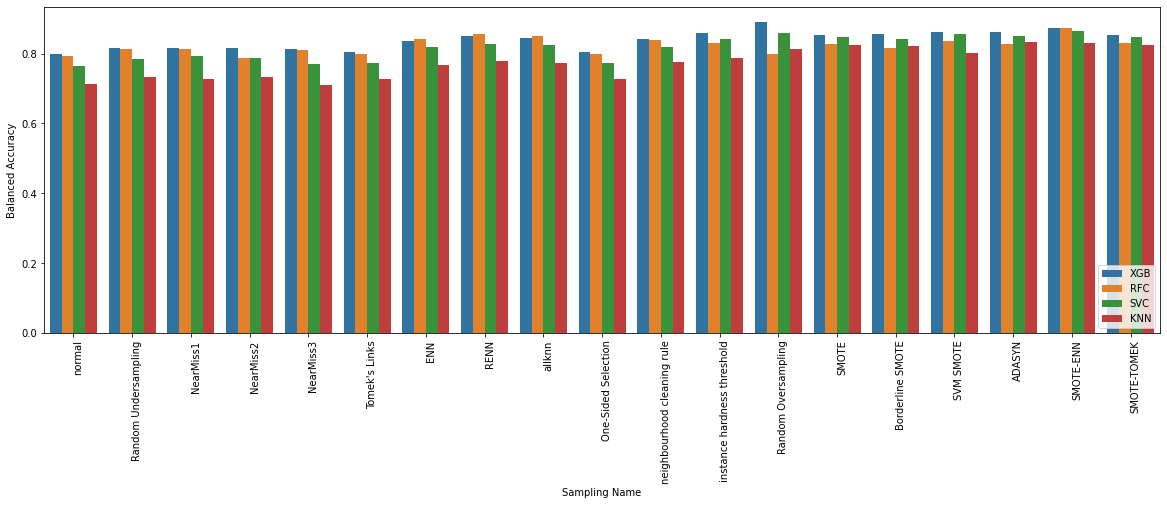

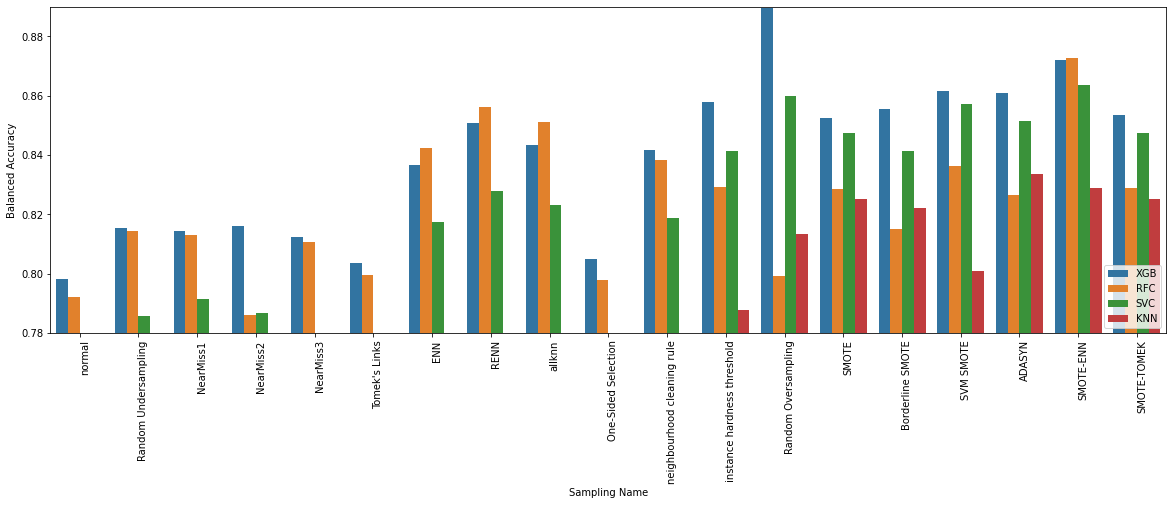

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = allsample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_ylim(0.78,0.89)
ax1.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="Balanced Accuracy", data = allsample_df, hue="Estimator",);
plt.legend(loc='lower right');

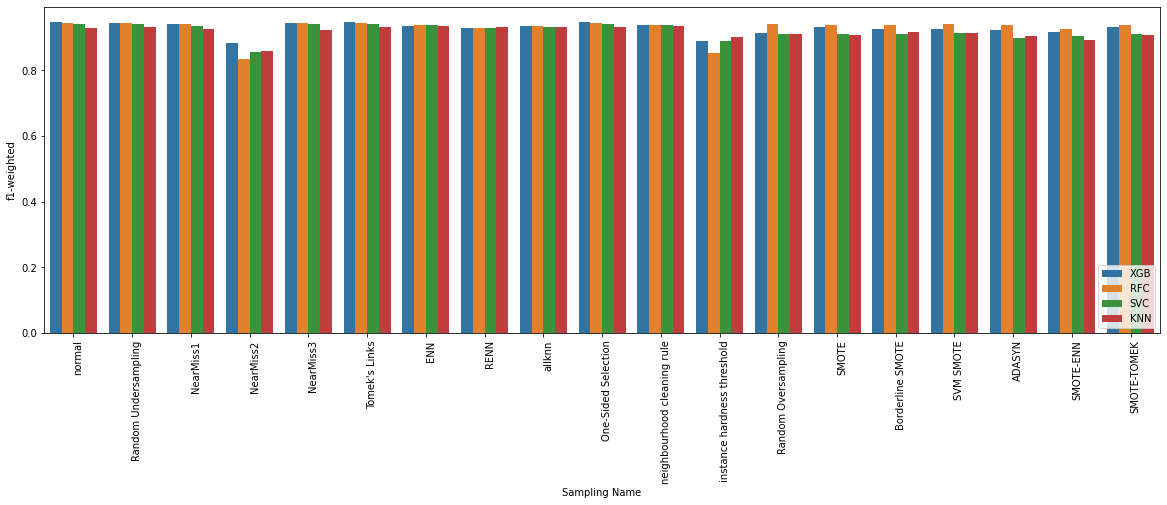

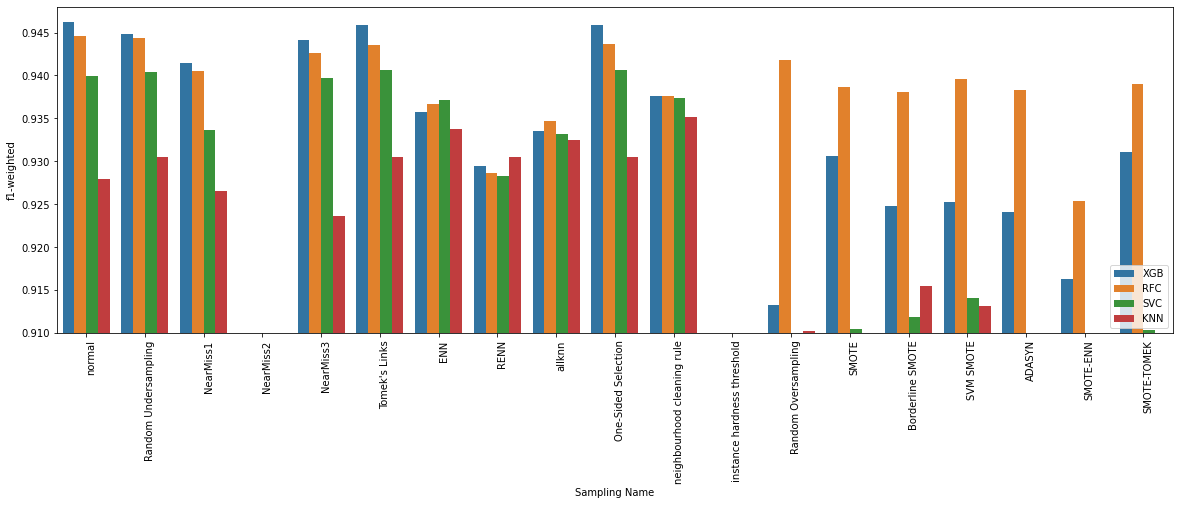

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = allsample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_ylim(0.910,0.948)
ax1.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="f1-weighted", data = allsample_df, hue="Estimator",);
plt.legend(loc='lower right');

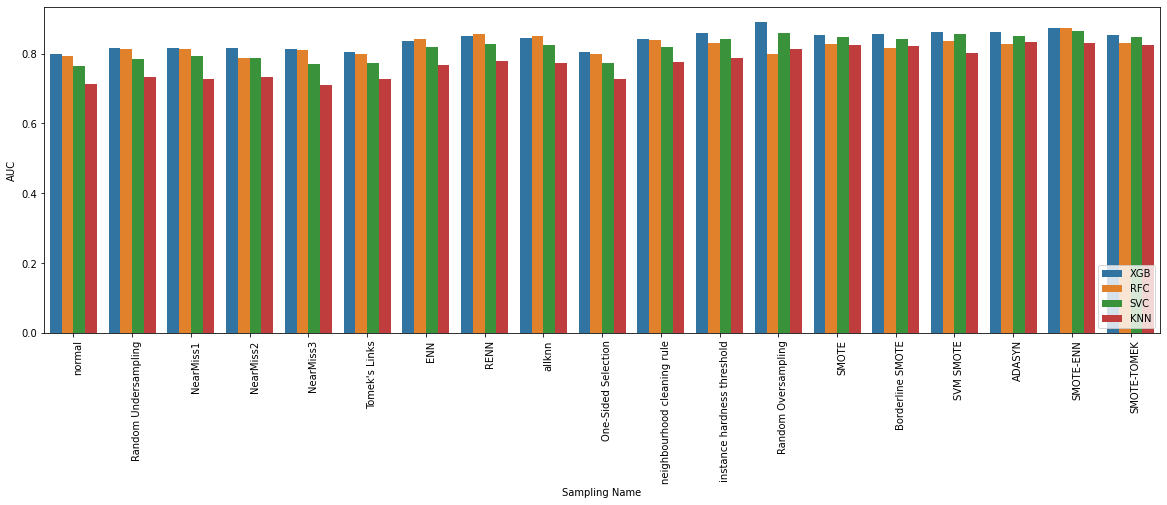

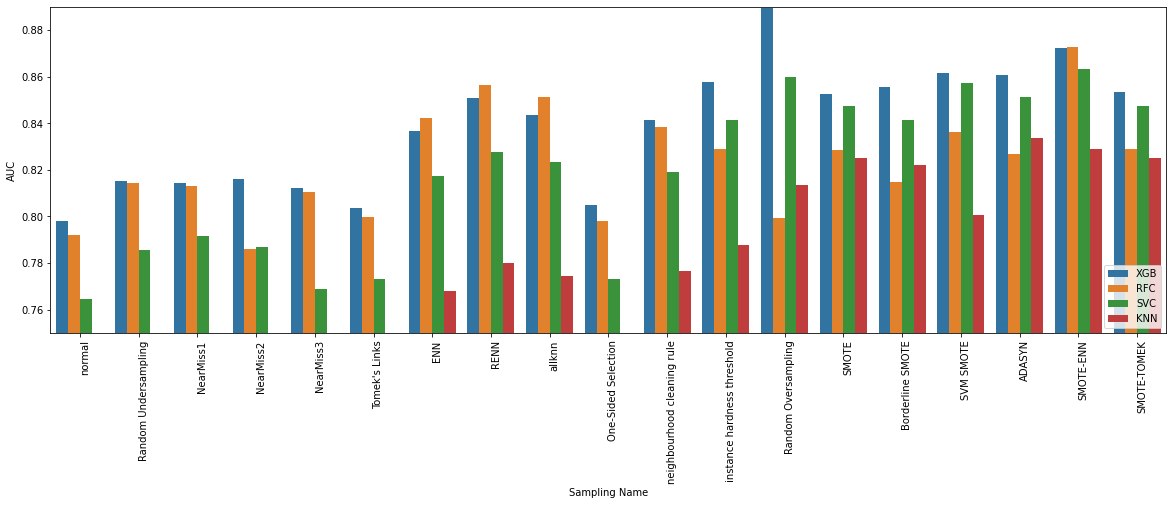

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = allsample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_ylim(0.75,0.89)
ax1.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="AUC", data = allsample_df, hue="Estimator",);
plt.legend(loc='lower right');

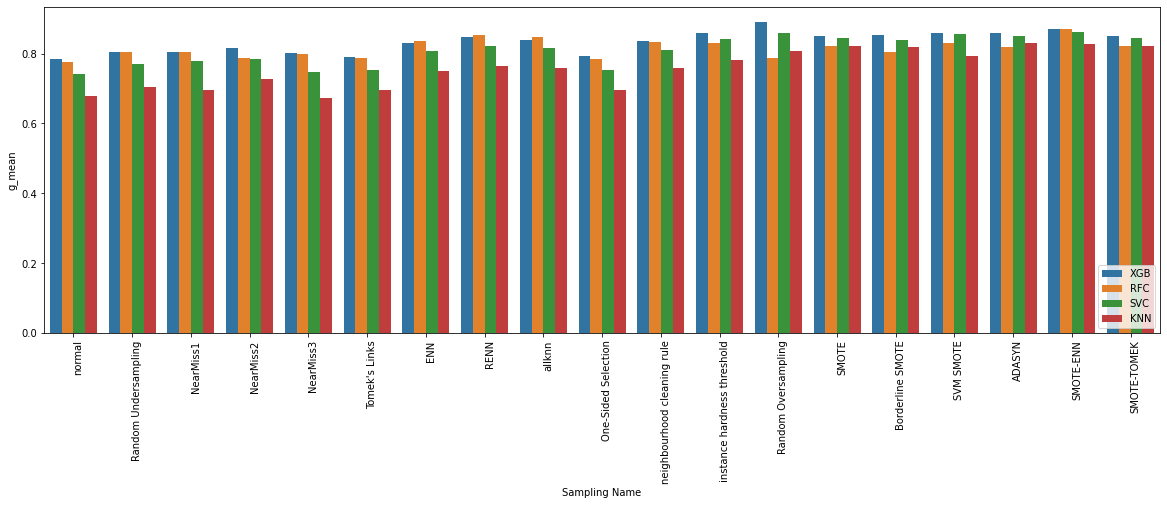

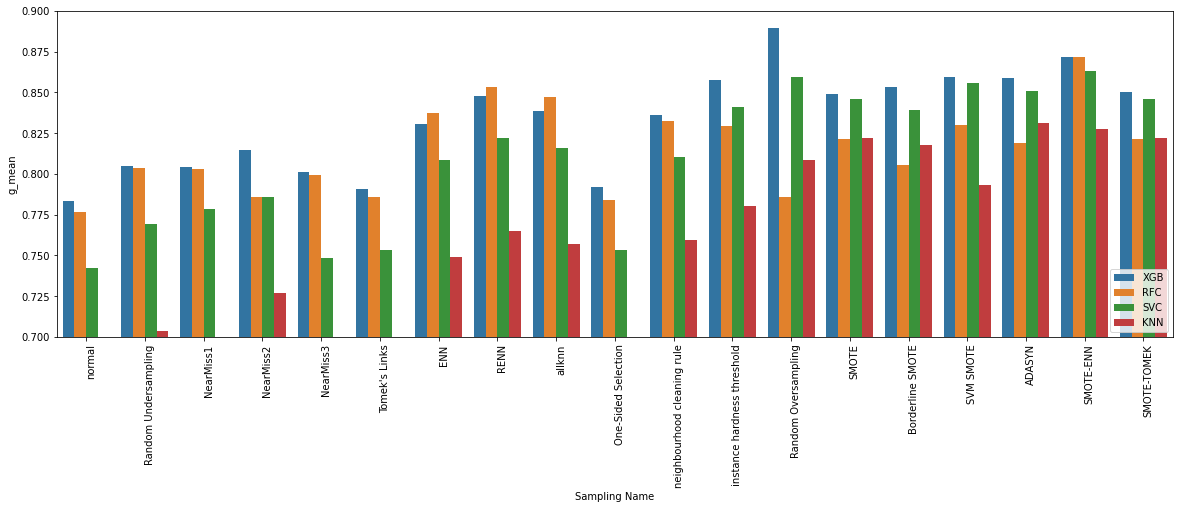

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = allsample_df, hue="Estimator");
plt.legend(loc='lower right')

f, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_ylim(0.70,0.90)
ax1.set_xticklabels(rotation = 90, labels=allsample_df["Sampling Name"], horizontalalignment='left')
sns.barplot(x="Sampling Name", y="g_mean", data = allsample_df, hue="Estimator",);
plt.legend(loc='lower right');